<a href="https://colab.research.google.com/github/ParthKulkarni445/BlueMoon-Simulator/blob/main/Portfolio_Implied_Volatility.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Utilities**

In [5]:
import yfinance as yf
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import optuna
import warnings
from scipy.stats import pearsonr
from itertools import combinations
import pickle
import os
from datetime import datetime

warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

class StockDataset(Dataset):
    """Custom Dataset class for stock price sequences"""
    def __init__(self, sequences, targets):
        self.sequences = sequences
        self.targets = targets

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return torch.FloatTensor(self.sequences[idx]), torch.FloatTensor([self.targets[idx]])

class PortfolioDataset(Dataset):
    """Dataset for portfolio-level predictions"""
    def __init__(self, features, targets):
        self.features = features
        self.targets = targets

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return torch.FloatTensor(self.features[idx]), torch.FloatTensor([self.targets[idx]])

def calculate_realized_volatility(prices, window=20):
    """Calculate realized volatility using rolling window"""
    returns = np.log(prices / prices.shift(1)).dropna()
    realized_vol = returns.rolling(window=window).std() * np.sqrt(252)  # Annualized
    return realized_vol

def create_stock_features(data, lookback_window=60):
    """Create features from individual stock data"""
    # Basic price features
    data['Returns'] = np.log(data['Close'] / data['Close'].shift(1))
    data['High_Low_Pct'] = (data['High'] - data['Low']) / data['Close']
    data['Open_Close_Pct'] = (data['Close'] - data['Open']) / data['Open']

    # Moving averages
    data['MA_5'] = data['Close'].rolling(window=5).mean()
    data['MA_20'] = data['Close'].rolling(window=20).mean()
    data['MA_Ratio'] = data['MA_5'] / data['MA_20']

    # Volatility features
    data['Realized_Vol'] = calculate_realized_volatility(data['Close'])
    data['Vol_MA'] = data['Realized_Vol'].rolling(window=10).mean()

    # Volume features
    data['Volume_MA'] = data['Volume'].rolling(window=20).mean()
    volume_series = pd.Series(data['Volume'].values.flatten(), index=data.index)
    data['Volume_Ratio'] = (volume_series / data['Volume_MA']).fillna(1.0)

    # RSI (Relative Strength Index)
    delta = data['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / loss
    data['RSI'] = 100 - (100 / (1 + rs))

    # Select features for model input
    feature_columns = [
        'Open', 'High', 'Low', 'Close', 'Volume',
        'Returns', 'High_Low_Pct', 'Open_Close_Pct',
        'MA_Ratio', 'Volume_Ratio', 'RSI'
    ]

    # Clean up any infinite or NaN values
    data = data.replace([np.inf, -np.inf], np.nan)
    data = data.fillna(method='ffill').fillna(method='bfill')

    # Target: Future realized volatility (proxy for implied volatility)
    data['Target_IV'] = data['Realized_Vol'].shift(-5)  # 5-day ahead volatility

    return data[feature_columns + ['Target_IV']].dropna()

def prepare_stock_sequences(data, sequence_length=60):
    """Prepare sequences for LSTM training"""
    feature_columns = [col for col in data.columns if col != 'Target_IV']

    # Scale features
    feature_scaler = MinMaxScaler()
    target_scaler = MinMaxScaler()

    scaled_features = feature_scaler.fit_transform(data[feature_columns])
    scaled_targets = target_scaler.fit_transform(data[['Target_IV']])

    sequences = []
    targets = []

    for i in range(sequence_length, len(scaled_features)):
        sequences.append(scaled_features[i-sequence_length:i])
        targets.append(scaled_targets[i, 0])

    return np.array(sequences), np.array(targets), feature_scaler, target_scaler

def save_model(model, filepath, scalers=None, metadata=None):
    """Save model with scalers and metadata"""
    save_dict = {
        'model_state_dict': model.state_dict(),
        'model_class': model.__class__.__name__,
        'scalers': scalers,
        'metadata': metadata,
        'timestamp': datetime.now().isoformat()
    }

    torch.save(save_dict, filepath)
    print(f"Model saved to {filepath}")

def load_model(filepath, model_class):
    """Load model with scalers and metadata"""
    checkpoint = torch.load(filepath)

    # You'll need to instantiate the model with the correct parameters
    # This is a simplified version - you might need to save model parameters too
    model = model_class()
    model.load_state_dict(checkpoint['model_state_dict'])

    return model, checkpoint.get('scalers'), checkpoint.get('metadata')


# **Stage I : Stock IV Forecasting**

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import optuna
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error

class LSTMModel(nn.Module):
    """LSTM Model for Individual Stock IV Prediction"""
    def __init__(self, input_size, hidden_size, num_layers, dropout_rate=0.2):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # LSTM layers with dropout
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            dropout=dropout_rate if num_layers > 1 else 0,
            batch_first=True
        )

        # Batch normalization
        self.batch_norm = nn.BatchNorm1d(hidden_size)

        # Fully connected layers
        self.fc1 = nn.Linear(hidden_size, hidden_size // 2)
        self.fc2 = nn.Linear(hidden_size // 2, 1)

        # Dropout and activation
        self.dropout = nn.Dropout(dropout_rate)
        self.relu = nn.ReLU()

    def forward(self, x):
        # Initialize hidden state
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        # LSTM forward pass
        lstm_out, _ = self.lstm(x, (h0, c0))

        # Take the last output
        last_output = lstm_out[:, -1, :]

        # Batch normalization
        normalized = self.batch_norm(last_output)

        # Fully connected layers
        out = self.relu(self.fc1(normalized))
        out = self.dropout(out)
        out = self.fc2(out)

        return out

def train_lstm_model(model, train_loader, val_loader, num_epochs, learning_rate, device):
    """Train individual stock LSTM model"""
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=10, factor=0.5)

    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    patience_counter = 0
    patience = 20

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0

        for sequences, targets in train_loader:
            sequences, targets = sequences.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs = model(sequences)
            loss = criterion(outputs, targets)
            loss.backward()

            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            optimizer.step()
            train_loss += loss.item()

        # Validation phase
        model.eval()
        val_loss = 0.0

        with torch.no_grad():
            for sequences, targets in val_loader:
                sequences, targets = sequences.to(device), targets.to(device)
                outputs = model(sequences)
                loss = criterion(outputs, targets)
                val_loss += loss.item()

        train_loss /= len(train_loader)
        val_loss /= len(val_loader)

        train_losses.append(train_loss)
        val_losses.append(val_loss)

        scheduler.step(val_loss)

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            break

        if (epoch + 1) % 20 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}')

    return train_losses, val_losses, best_val_loss

def optimize_lstm_hyperparameters(X_train, y_train, X_val, y_val, input_size, device, n_trials=50):
    """Optimize LSTM hyperparameters using Optuna"""

    def objective(trial):
        # Suggest hyperparameters
        hidden_size = trial.suggest_categorical('hidden_size', [64, 128])
        num_layers = trial.suggest_int('num_layers', 1, 2)
        dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)
        learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
        batch_size = trial.suggest_categorical('batch_size', [16, 32, 64])

        # Create model
        model = LSTMModel(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            dropout_rate=dropout_rate
        ).to(device)

        # Create datasets
        train_dataset = StockDataset(X_train, y_train)
        val_dataset = StockDataset(X_val, y_val)

        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

        # Train model
        _, _, best_val_loss = train_lstm_model(
            model, train_loader, val_loader, 50, learning_rate, device
        )

        return best_val_loss

    # Create study and optimize
    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=n_trials, show_progress_bar=True)

    print("Best hyperparameters:")
    for key, value in study.best_params.items():
        print(f"  {key}: {value}")

    return study.best_params


# **Portfolio Features**

In [7]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

def calculate_correlation_matrix(returns_data, window=60):
    """Calculate rolling correlation matrix between stocks"""
    correlations = []
    correlation_dates = []

    for i in range(window, len(returns_data)):
        window_data = returns_data.iloc[i-window:i]
        corr_matrix = window_data.corr().values
        # Replace NaN with 0
        corr_matrix = np.nan_to_num(corr_matrix)
        correlations.append(corr_matrix)
        correlation_dates.append(returns_data.index[i])

    return np.array(correlations), correlation_dates

def create_portfolio_features(individual_ivs, weights, correlations, correlation_dates, market_data):
    """
    Create portfolio-level features for Stage II
    Args:
        individual_ivs: Dict of individual stock IV predictions
        weights: Portfolio weights for each stock
        correlations: Correlation matrices over time
        correlation_dates: Dates corresponding to correlation matrices
        market_data: Market-wide indicators (VIX, etc.)
    """
    features = []
    feature_dates = []

    # Find common dates across all individual IV predictions
    aligned_dates = None
    for ticker, iv_series in individual_ivs.items():
        if aligned_dates is None:
            aligned_dates = iv_series.index
        else:
            aligned_dates = aligned_dates.intersection(iv_series.index)

    aligned_dates = aligned_dates.sort_values()
    correlation_dates_index = pd.Index(correlation_dates)

    # Find intersection of aligned dates and correlation dates
    common_dates = aligned_dates.intersection(correlation_dates_index)

    for date in common_dates:
        feature_vector = []

        # Individual stock IVs
        stock_ivs = []
        for ticker in individual_ivs.keys():
            if date in individual_ivs[ticker].index:
                stock_ivs.append(individual_ivs[ticker].loc[date])
            else:
                if not individual_ivs[ticker].empty:
                    stock_ivs.append(individual_ivs[ticker].iloc[-1])
                else:
                    stock_ivs.append(0)

        feature_vector.extend(stock_ivs)

        # Portfolio weights
        feature_vector.extend(weights[:len(stock_ivs)])

        # Correlation features
        if date in correlation_dates_index:
            corr_index = correlation_dates_index.get_loc(date)
            corr_matrix = correlations[corr_index]

            if corr_matrix.shape[0] == len(stock_ivs):
                # Extract upper triangular correlation values
                upper_tri_indices = np.triu_indices_from(corr_matrix, k=1)
                if len(upper_tri_indices[0]) > 0:
                    avg_correlation = np.mean(corr_matrix[upper_tri_indices])
                    max_correlation = np.max(corr_matrix[upper_tri_indices])
                    min_correlation = np.min(corr_matrix[upper_tri_indices])
                    feature_vector.extend([avg_correlation, max_correlation, min_correlation])
                else:
                    feature_vector.extend([0, 0, 0])
            else:
                feature_vector.extend([np.nan, np.nan, np.nan])
        else:
            feature_vector.extend([np.nan, np.nan, np.nan])

        # Market regime indicators
        if market_data is not None and date in market_data.index:
            if 'VIX' in market_data.columns:
                vix_val = market_data.loc[date, 'VIX']
                feature_vector.append(vix_val if not np.isnan(vix_val) else 0)
            else:
                feature_vector.append(0)

            if 'Market_Vol' in market_data.columns:
                market_vol = market_data.loc[date, 'Market_Vol']
                feature_vector.append(market_vol if not np.isnan(market_vol) else 0)
            else:
                feature_vector.append(0)
        else:
            feature_vector.extend([0, 0])

        # Portfolio-level statistics
        if len(stock_ivs) == len(weights[:len(stock_ivs)]):
            weighted_iv = np.sum(np.array(stock_ivs) * np.array(weights[:len(stock_ivs)]))
            iv_dispersion = np.std(stock_ivs) if len(stock_ivs) > 1 else 0
            feature_vector.extend([weighted_iv, iv_dispersion])
        else:
            feature_vector.extend([np.nan, np.nan])

        features.append(feature_vector)
        feature_dates.append(date)

    # Convert to DataFrame and handle NaNs
    features_df = pd.DataFrame(features, index=feature_dates)
    features_df = features_df.fillna(0)  # Fill NaNs with 0 instead of dropping

    return features_df.values, features_df.index

def calculate_portfolio_iv_target(individual_ivs, weights, correlations, correlation_dates):
    """
    Calculate target portfolio IV using correlation-adjusted formula
    Portfolio Variance = w^T * Σ * w
    where Σ is the covariance matrix
    """
    targets = []
    target_dates = []

    # Find common dates
    aligned_dates = None
    for ticker, iv_series in individual_ivs.items():
        if aligned_dates is None:
            aligned_dates = iv_series.index
        else:
            aligned_dates = aligned_dates.intersection(iv_series.index)

    aligned_dates = aligned_dates.sort_values()
    correlation_dates_index = pd.Index(correlation_dates)
    common_dates = aligned_dates.intersection(correlation_dates_index)

    for date in common_dates:
        # Get individual IVs for this time period
        ivs = []
        for ticker in individual_ivs.keys():
            if date in individual_ivs[ticker].index:
                ivs.append(individual_ivs[ticker].loc[date])
            else:
                if not individual_ivs[ticker].empty:
                    ivs.append(individual_ivs[ticker].iloc[-1])
                else:
                    ivs.append(0)

        ivs = np.array(ivs)
        weights_array = np.array(weights[:len(ivs)])

        # Get corresponding correlation matrix
        if date in correlation_dates_index:
            corr_index = correlation_dates_index.get_loc(date)
            corr_matrix = correlations[corr_index]

            if corr_matrix.shape[0] == len(ivs):
                # Create covariance matrix from correlations and individual volatilities
                cov_matrix = np.outer(ivs, ivs) * corr_matrix

                # Calculate portfolio variance
                portfolio_var = np.dot(weights_array, np.dot(cov_matrix, weights_array))
                portfolio_iv = np.sqrt(max(portfolio_var, 0))  # Ensure non-negative

                targets.append(portfolio_iv)
                target_dates.append(date)

    return np.array(targets), target_dates


# **Stage 2 : Portfolio IV Prediction**

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import optuna
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.stats import pearsonr

class PortfolioMLPModel(nn.Module):
    """
    Multi-Layer Perceptron for Portfolio IV Prediction
    Input Features:
    - Individual stock IV predictions
    - Portfolio weights
    - Pairwise correlations
    - Market regime indicators
    """
    def __init__(self, input_size, hidden_sizes=[128, 64, 32], dropout_rate=0.3):
        super(PortfolioMLPModel, self).__init__()

        layers = []
        prev_size = input_size

        for hidden_size in hidden_sizes:
            layers.extend([
                nn.Linear(prev_size, hidden_size),
                nn.BatchNorm1d(hidden_size),
                nn.ReLU(),
                nn.Dropout(dropout_rate)
            ])
            prev_size = hidden_size

        # Output layer
        layers.append(nn.Linear(prev_size, 1))

        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

class PortfolioGNNModel(nn.Module):
    """
    Graph Neural Network for Portfolio IV Prediction
    Models stock relationships through correlation graph
    """
    def __init__(self, num_stocks, feature_dim, hidden_dim=64):
        super(PortfolioGNNModel, self).__init__()
        self.num_stocks = num_stocks
        self.feature_dim = feature_dim
        self.hidden_dim = hidden_dim

        # Node feature transformation
        self.node_transform = nn.Linear(feature_dim, hidden_dim)

        # Graph convolution layers
        self.gconv1 = nn.Linear(hidden_dim, hidden_dim)
        self.gconv2 = nn.Linear(hidden_dim, hidden_dim)

        # Portfolio aggregation
        self.portfolio_fc = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim // 2, 1)
        )

    def forward(self, node_features, adjacency_matrix, weights):
        # Transform node features
        h = torch.relu(self.node_transform(node_features))

        # Graph convolution layers
        h = torch.relu(self.gconv1(torch.matmul(adjacency_matrix, h)))
        h = torch.relu(self.gconv2(torch.matmul(adjacency_matrix, h)))

        # Weighted aggregation based on portfolio weights
        portfolio_embedding = torch.sum(h * weights.unsqueeze(-1), dim=1)

        # Final prediction
        output = self.portfolio_fc(portfolio_embedding)
        return output

def train_portfolio_model(model, train_loader, val_loader, num_epochs, learning_rate, device):
    """Train portfolio-level model"""
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=15, factor=0.5)

    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    patience_counter = 0
    patience = 25

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0

        for features, targets in train_loader:
            features, targets = features.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs = model(features)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        # Validation phase
        model.eval()
        val_loss = 0.0

        with torch.no_grad():
            for features, targets in val_loader:
                features, targets = features.to(device), targets.to(device)
                outputs = model(features)
                loss = criterion(outputs, targets)
                val_loss += loss.item()

        train_loss /= len(train_loader)
        val_loss /= len(val_loader)

        train_losses.append(train_loss)
        val_losses.append(val_loss)

        scheduler.step(val_loss)

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            break

        if (epoch + 1) % 20 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}')

    return train_losses, val_losses, best_val_loss

def optimize_mlp_hyperparameters(X_train, y_train, X_val, y_val, device, n_trials=30):
    """Optimize MLP hyperparameters using Optuna"""

    def objective(trial):
        # Suggest hyperparameters
        hidden_sizes = []
        n_layers = trial.suggest_int('n_layers', 2, 5)

        for i in range(n_layers):
            hidden_size = trial.suggest_categorical(f'hidden_size_{i}', [32, 64, 128, 256, 512])
            hidden_sizes.append(hidden_size)

        dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)
        learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
        batch_size = trial.suggest_categorical('batch_size', [16, 32, 64])

        # Create model
        model = PortfolioMLPModel(
            input_size=X_train.shape[1],
            hidden_sizes=hidden_sizes,
            dropout_rate=dropout_rate
        ).to(device)

        # Create datasets
        train_dataset = PortfolioDataset(X_train, y_train)
        val_dataset = PortfolioDataset(X_val, y_val)

        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

        # Train model
        _, _, best_val_loss = train_portfolio_model(
            model, train_loader, val_loader, 100, learning_rate, device
        )

        return best_val_loss

    # Create study and optimize
    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=n_trials, show_progress_bar=True)

    print("Best MLP hyperparameters:")
    for key, value in study.best_params.items():
        print(f"  {key}: {value}")

    return study.best_params


# **Plotting Utilities**

In [8]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.stats import pearsonr

def plot_stage1_results(train_losses, val_losses, y_true, y_pred, ticker):
    """Plot Stage I (individual stock) results"""
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle(f'Stage I Results - {ticker}', fontsize=16)

    # Training history
    axes[0, 0].plot(train_losses, label='Training Loss', alpha=0.8)
    axes[0, 0].plot(val_losses, label='Validation Loss', alpha=0.8)
    axes[0, 0].set_title('Training History')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss (MSE)')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # Scatter plot
    axes[0, 1].scatter(y_true, y_pred, alpha=0.6)
    axes[0, 1].plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2)
    axes[0, 1].set_xlabel('Actual IV')
    axes[0, 1].set_ylabel('Predicted IV')
    axes[0, 1].set_title('Actual vs Predicted')
    axes[0, 1].grid(True, alpha=0.3)

    # Time series comparison
    axes[0, 2].plot(y_true[:200], label='Actual', alpha=0.8)
    axes[0, 2].plot(y_pred[:200], label='Predicted', alpha=0.8)
    axes[0, 2].set_title('Time Series (First 200 points)')
    axes[0, 2].set_xlabel('Time')
    axes[0, 2].set_ylabel('IV')
    axes[0, 2].legend()
    axes[0, 2].grid(True, alpha=0.3)

    # Residuals
    residuals = y_true - y_pred
    axes[1, 0].scatter(y_pred, residuals, alpha=0.6)
    axes[1, 0].axhline(y=0, color='r', linestyle='--')
    axes[1, 0].set_xlabel('Predicted IV')
    axes[1, 0].set_ylabel('Residuals')
    axes[1, 0].set_title('Residuals Plot')
    axes[1, 0].grid(True, alpha=0.3)

    # Residuals distribution
    axes[1, 1].hist(residuals, bins=30, alpha=0.7, edgecolor='black')
    axes[1, 1].set_xlabel('Residuals')
    axes[1, 1].set_ylabel('Frequency')
    axes[1, 1].set_title('Residuals Distribution')
    axes[1, 1].grid(True, alpha=0.3)

    # Error over time
    axes[1, 2].plot(np.abs(residuals), alpha=0.7)
    axes[1, 2].set_xlabel('Time')
    axes[1, 2].set_ylabel('Absolute Error')
    axes[1, 2].set_title('Absolute Error Over Time')
    axes[1, 2].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

def plot_stage2_results(train_losses, val_losses, y_true, y_pred, model_name):
    """Plot Stage II (portfolio) results"""
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle(f'Stage II Results - {model_name}', fontsize=16)

    # Training history
    axes[0, 0].plot(train_losses, label='Training Loss', alpha=0.8)
    axes[0, 0].plot(val_losses, label='Validation Loss', alpha=0.8)
    axes[0, 0].set_title('Training History')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss (MSE)')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # Scatter plot
    axes[0, 1].scatter(y_true, y_pred, alpha=0.6)
    axes[0, 1].plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2)
    axes[0, 1].set_xlabel('Actual Portfolio IV')
    axes[0, 1].set_ylabel('Predicted Portfolio IV')
    axes[0, 1].set_title('Actual vs Predicted')
    axes[0, 1].grid(True, alpha=0.3)

    # Time series comparison
    axes[0, 2].plot(y_true, label='Actual', alpha=0.8)
    axes[0, 2].plot(y_pred, label='Predicted', alpha=0.8)
    axes[0, 2].set_title('Portfolio IV Time Series')
    axes[0, 2].set_xlabel('Time')
    axes[0, 2].set_ylabel('Portfolio IV')
    axes[0, 2].legend()
    axes[0, 2].grid(True, alpha=0.3)

    # Residuals
    residuals = y_true - y_pred
    axes[1, 0].scatter(y_pred, residuals, alpha=0.6)
    axes[1, 0].axhline(y=0, color='r', linestyle='--')
    axes[1, 0].set_xlabel('Predicted Portfolio IV')
    axes[1, 0].set_ylabel('Residuals')
    axes[1, 0].set_title('Residuals Plot')
    axes[1, 0].grid(True, alpha=0.3)

    # Residuals distribution
    axes[1, 1].hist(residuals, bins=30, alpha=0.7, edgecolor='black')
    axes[1, 1].set_xlabel('Residuals')
    axes[1, 1].set_ylabel('Frequency')
    axes[1, 1].set_title('Residuals Distribution')
    axes[1, 1].grid(True, alpha=0.3)

    # Correlation analysis
    correlation, p_value = pearsonr(y_true, y_pred)
    axes[1, 2].text(0.1, 0.9, f'Correlation: {correlation:.4f}', transform=axes[1, 2].transAxes, fontsize=12)
    axes[1, 2].text(0.1, 0.8, f'P-value: {p_value:.4f}', transform=axes[1, 2].transAxes, fontsize=12)
    axes[1, 2].text(0.1, 0.7, f'RMSE: {np.sqrt(mean_squared_error(y_true, y_pred)):.4f}', transform=axes[1, 2].transAxes, fontsize=12)
    axes[1, 2].text(0.1, 0.6, f'MAE: {mean_absolute_error(y_true, y_pred):.4f}', transform=axes[1, 2].transAxes, fontsize=12)
    axes[1, 2].set_title('Model Performance Metrics')
    axes[1, 2].axis('off')

    plt.tight_layout()
    plt.show()

def plot_portfolio_comparison(results_dict):
    """Compare different portfolio models"""
    models = list(results_dict.keys())
    metrics = ['RMSE', 'MAE', 'Correlation']

    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    for i, metric in enumerate(metrics):
        values = []
        for model in models:
            if metric == 'RMSE':
                values.append(results_dict[model]['rmse'])
            elif metric == 'MAE':
                values.append(results_dict[model]['mae'])
            elif metric == 'Correlation':
                values.append(results_dict[model]['correlation'])

        axes[i].bar(models, values, alpha=0.7)
        axes[i].set_title(f'{metric} Comparison')
        axes[i].set_ylabel(metric)
        axes[i].tick_params(axis='x', rotation=45)
        axes[i].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()


# **Stage I Exexcution**

[*********************100%***********************]  1 of 1 completed

Using device: cpu
STAGE I: INDIVIDUAL STOCK IV PREDICTION

Processing MSFT...



[I 2025-07-03 12:37:14,578] A new study created in memory with name: no-name-f87289e0-9443-49c0-ae25-a5f8a235acfd


Optimizing hyperparameters for MSFT...


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [20/50], Train Loss: 0.002997, Val Loss: 0.000713
Epoch [40/50], Train Loss: 0.002397, Val Loss: 0.000749
[I 2025-07-03 12:37:43,453] Trial 0 finished with value: 0.0005143338090015782 and parameters: {'hidden_size': 64, 'num_layers': 1, 'dropout_rate': 0.21768047318972852, 'learning_rate': 0.005346881112339142, 'batch_size': 16}. Best is trial 0 with value: 0.0005143338090015782.
Epoch [20/50], Train Loss: 0.002066, Val Loss: 0.001540
Epoch [40/50], Train Loss: 0.001396, Val Loss: 0.000803
[I 2025-07-03 12:38:25,532] Trial 1 finished with value: 0.0006618594168685376 and parameters: {'hidden_size': 64, 'num_layers': 2, 'dropout_rate': 0.13612511665040233, 'learning_rate': 0.0030308540669107737, 'batch_size': 32}. Best is trial 0 with value: 0.0005143338090015782.
Epoch [20/50], Train Loss: 0.002238, Val Loss: 0.001403
Epoch [40/50], Train Loss: 0.001986, Val Loss: 0.000973
[I 2025-07-03 12:39:04,165] Trial 2 finished with value: 0.000931150687392801 and parameters: {'hidden_size

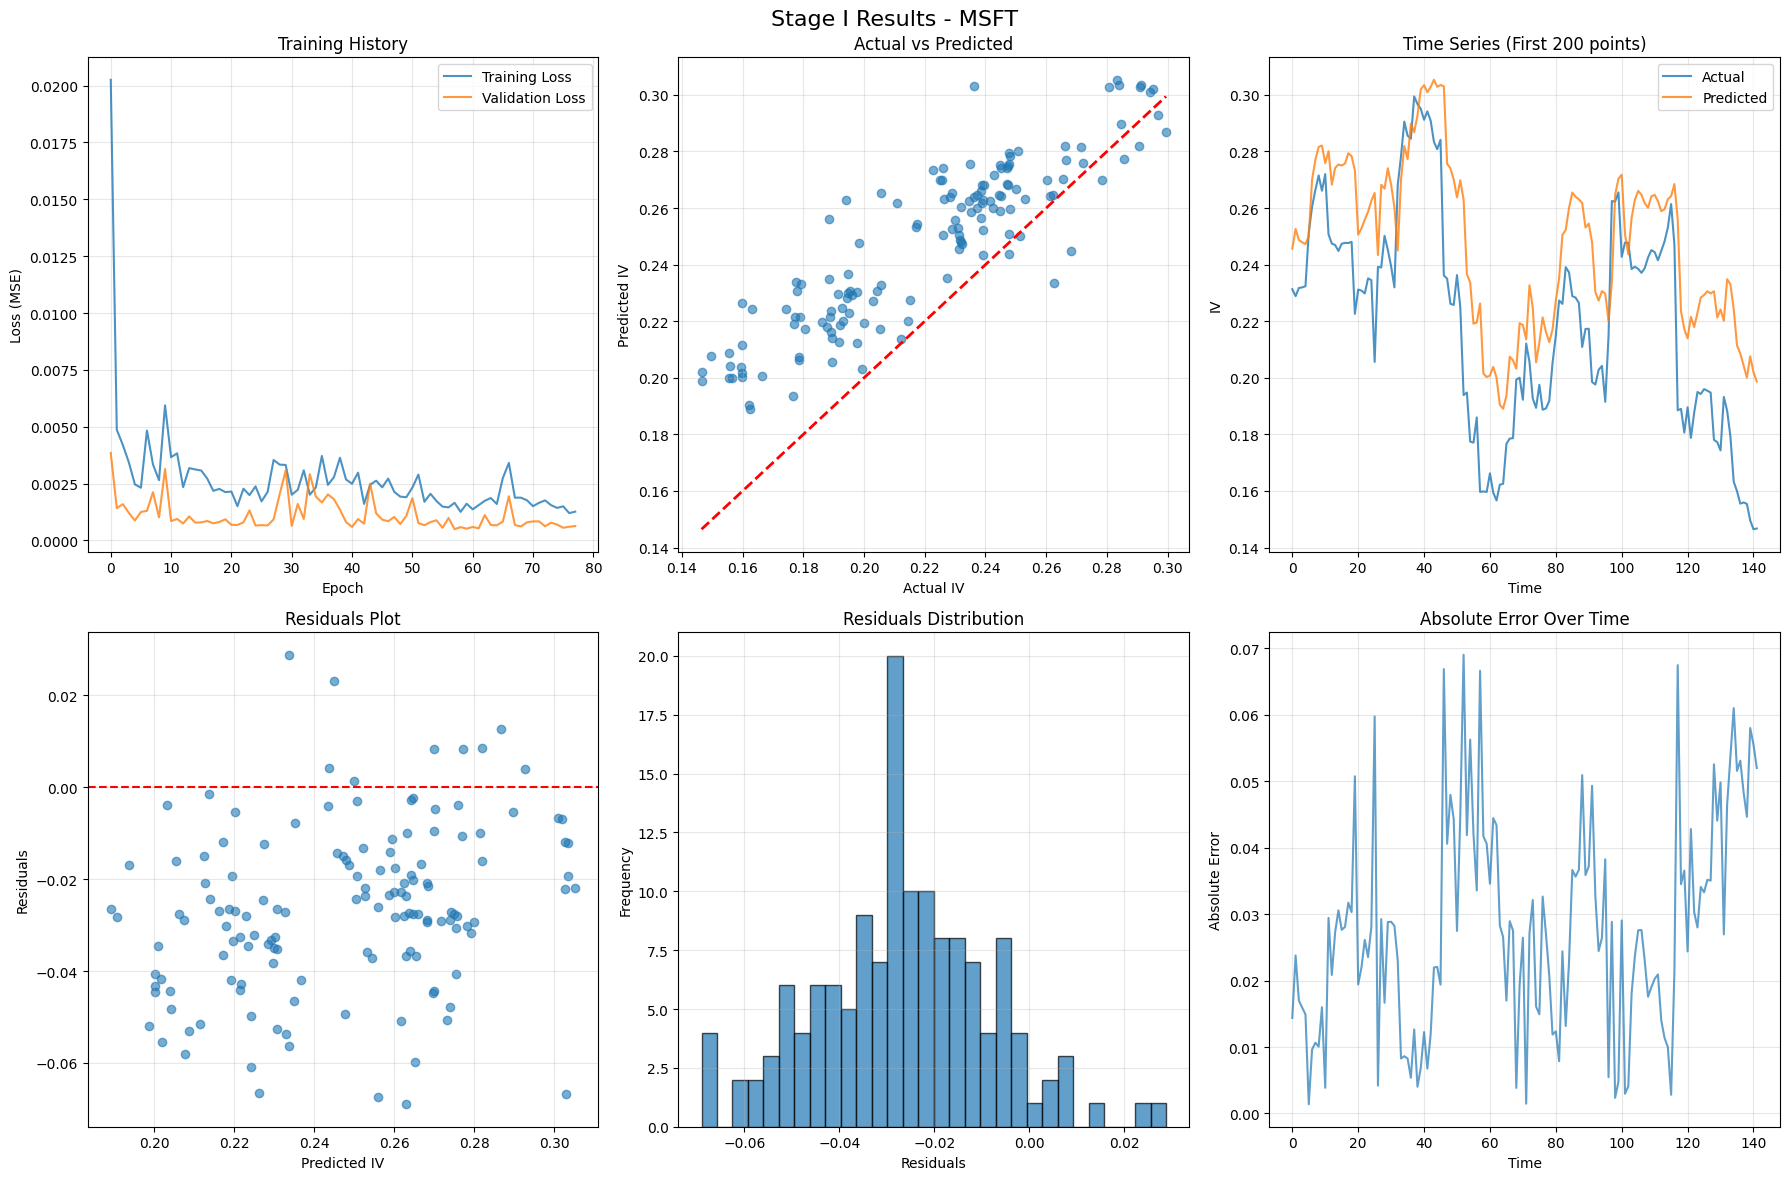

[*********************100%***********************]  1 of 1 completed
[I 2025-07-03 12:42:59,603] A new study created in memory with name: no-name-be2ffa94-3650-488e-9caa-494e2d178b2b



Processing NVDA...
Optimizing hyperparameters for NVDA...


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [20/50], Train Loss: 0.004133, Val Loss: 0.016988
Epoch [40/50], Train Loss: 0.002738, Val Loss: 0.010256
[I 2025-07-03 12:43:40,537] Trial 0 finished with value: 0.009091032474922637 and parameters: {'hidden_size': 64, 'num_layers': 2, 'dropout_rate': 0.33032092411031233, 'learning_rate': 0.0014508743861231014, 'batch_size': 64}. Best is trial 0 with value: 0.009091032474922637.
Epoch [20/50], Train Loss: 0.009007, Val Loss: 0.011580
Epoch [40/50], Train Loss: 0.005537, Val Loss: 0.008760
[I 2025-07-03 12:44:00,878] Trial 1 finished with value: 0.007824338196466366 and parameters: {'hidden_size': 64, 'num_layers': 1, 'dropout_rate': 0.19331035528736484, 'learning_rate': 0.00010589560926143136, 'batch_size': 64}. Best is trial 1 with value: 0.007824338196466366.
Epoch [20/50], Train Loss: 0.003354, Val Loss: 0.016543
Epoch [40/50], Train Loss: 0.001978, Val Loss: 0.010830
[I 2025-07-03 12:44:40,836] Trial 2 finished with value: 0.007804256863892078 and parameters: {'hidden_size':

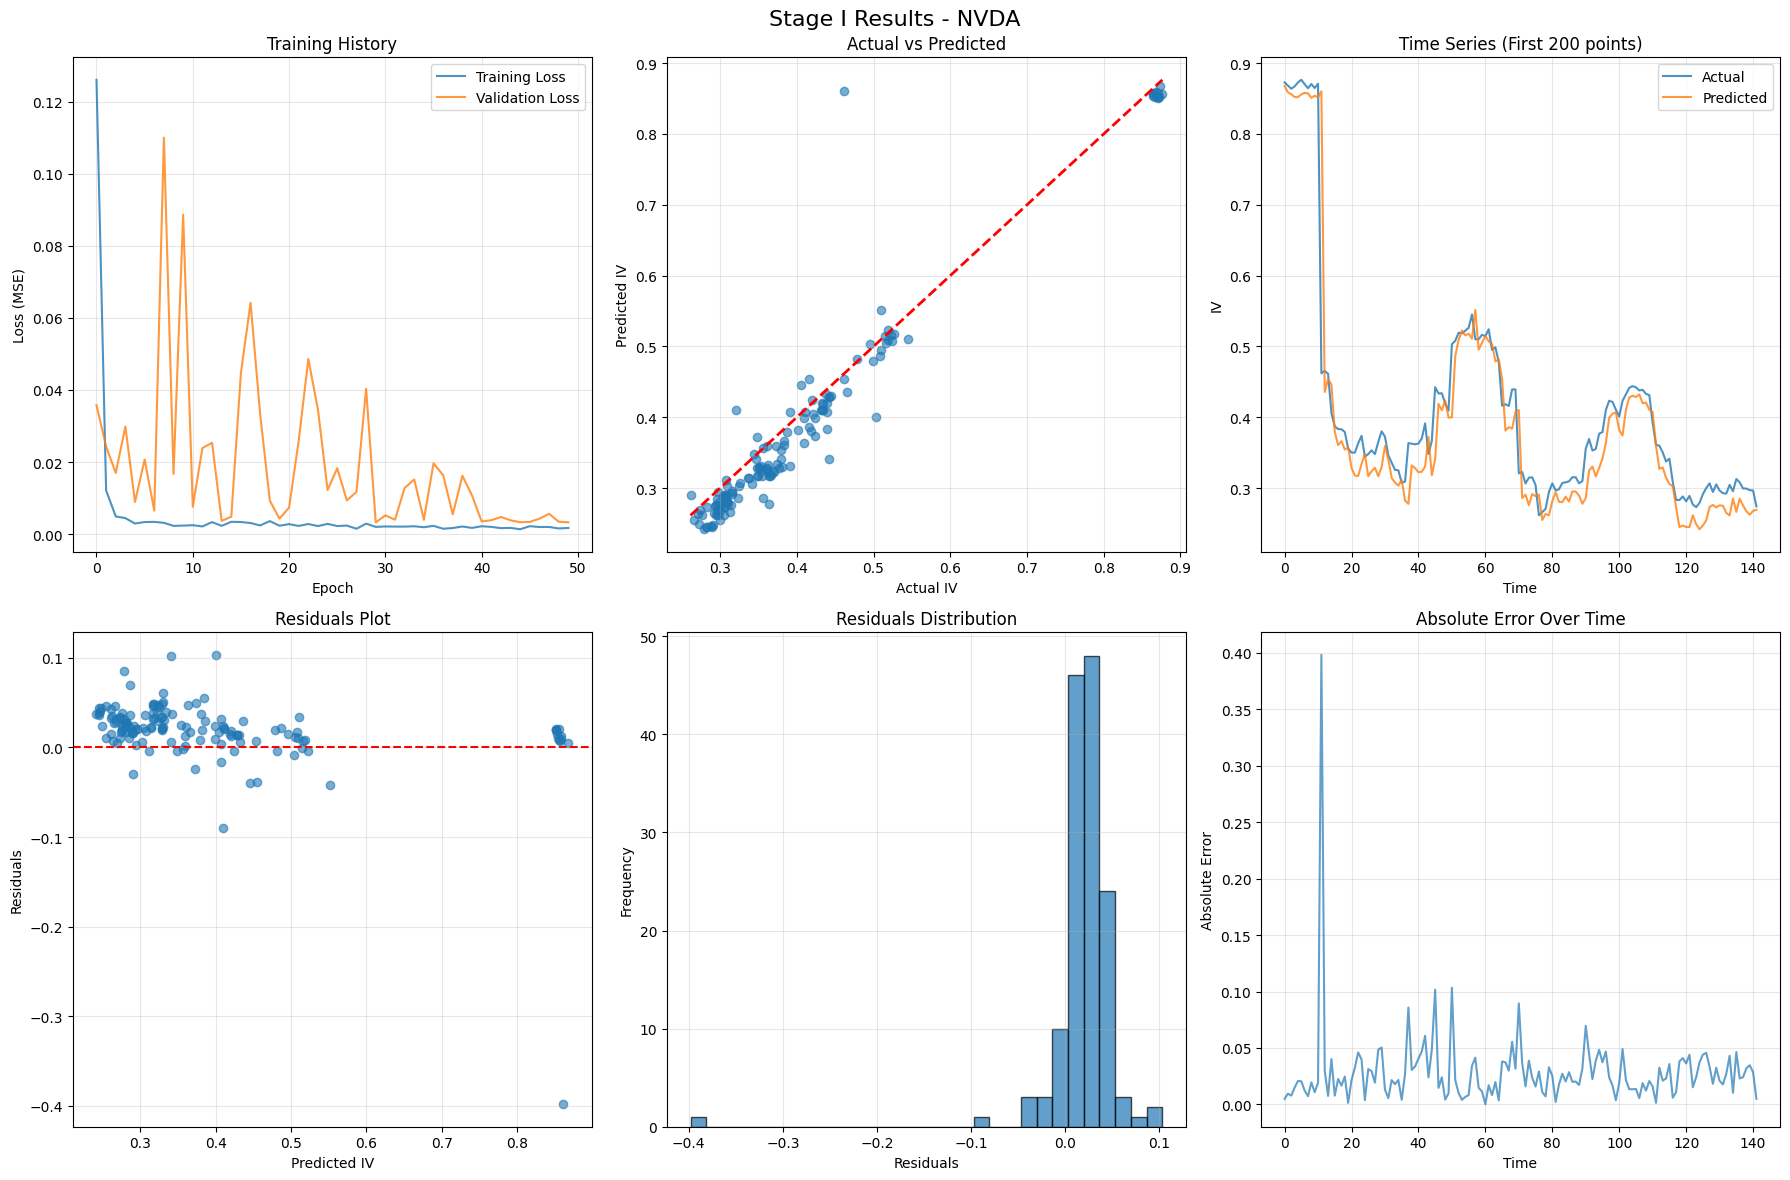

[*********************100%***********************]  1 of 1 completed
[I 2025-07-03 12:47:34,899] A new study created in memory with name: no-name-bc5a2824-62b6-422e-9e15-2048b12af0fe



Processing AAPL...
Optimizing hyperparameters for AAPL...


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [20/50], Train Loss: 0.002863, Val Loss: 0.001205
Epoch [40/50], Train Loss: 0.001825, Val Loss: 0.002081
[I 2025-07-03 12:48:18,656] Trial 0 finished with value: 0.00041049500287044794 and parameters: {'hidden_size': 64, 'num_layers': 2, 'dropout_rate': 0.12033593151903697, 'learning_rate': 0.00550943005124737, 'batch_size': 32}. Best is trial 0 with value: 0.00041049500287044794.
Epoch [20/50], Train Loss: 0.002453, Val Loss: 0.000655
Epoch [40/50], Train Loss: 0.002504, Val Loss: 0.002354
[I 2025-07-03 12:50:17,273] Trial 1 finished with value: 0.0005067008767380483 and parameters: {'hidden_size': 128, 'num_layers': 2, 'dropout_rate': 0.191384582160228, 'learning_rate': 0.0013996111559578406, 'batch_size': 16}. Best is trial 0 with value: 0.00041049500287044794.
Epoch [20/50], Train Loss: 0.002072, Val Loss: 0.000440
Epoch [40/50], Train Loss: 0.002510, Val Loss: 0.000733
[I 2025-07-03 12:50:47,378] Trial 2 finished with value: 0.0004175672511337325 and parameters: {'hidden_si

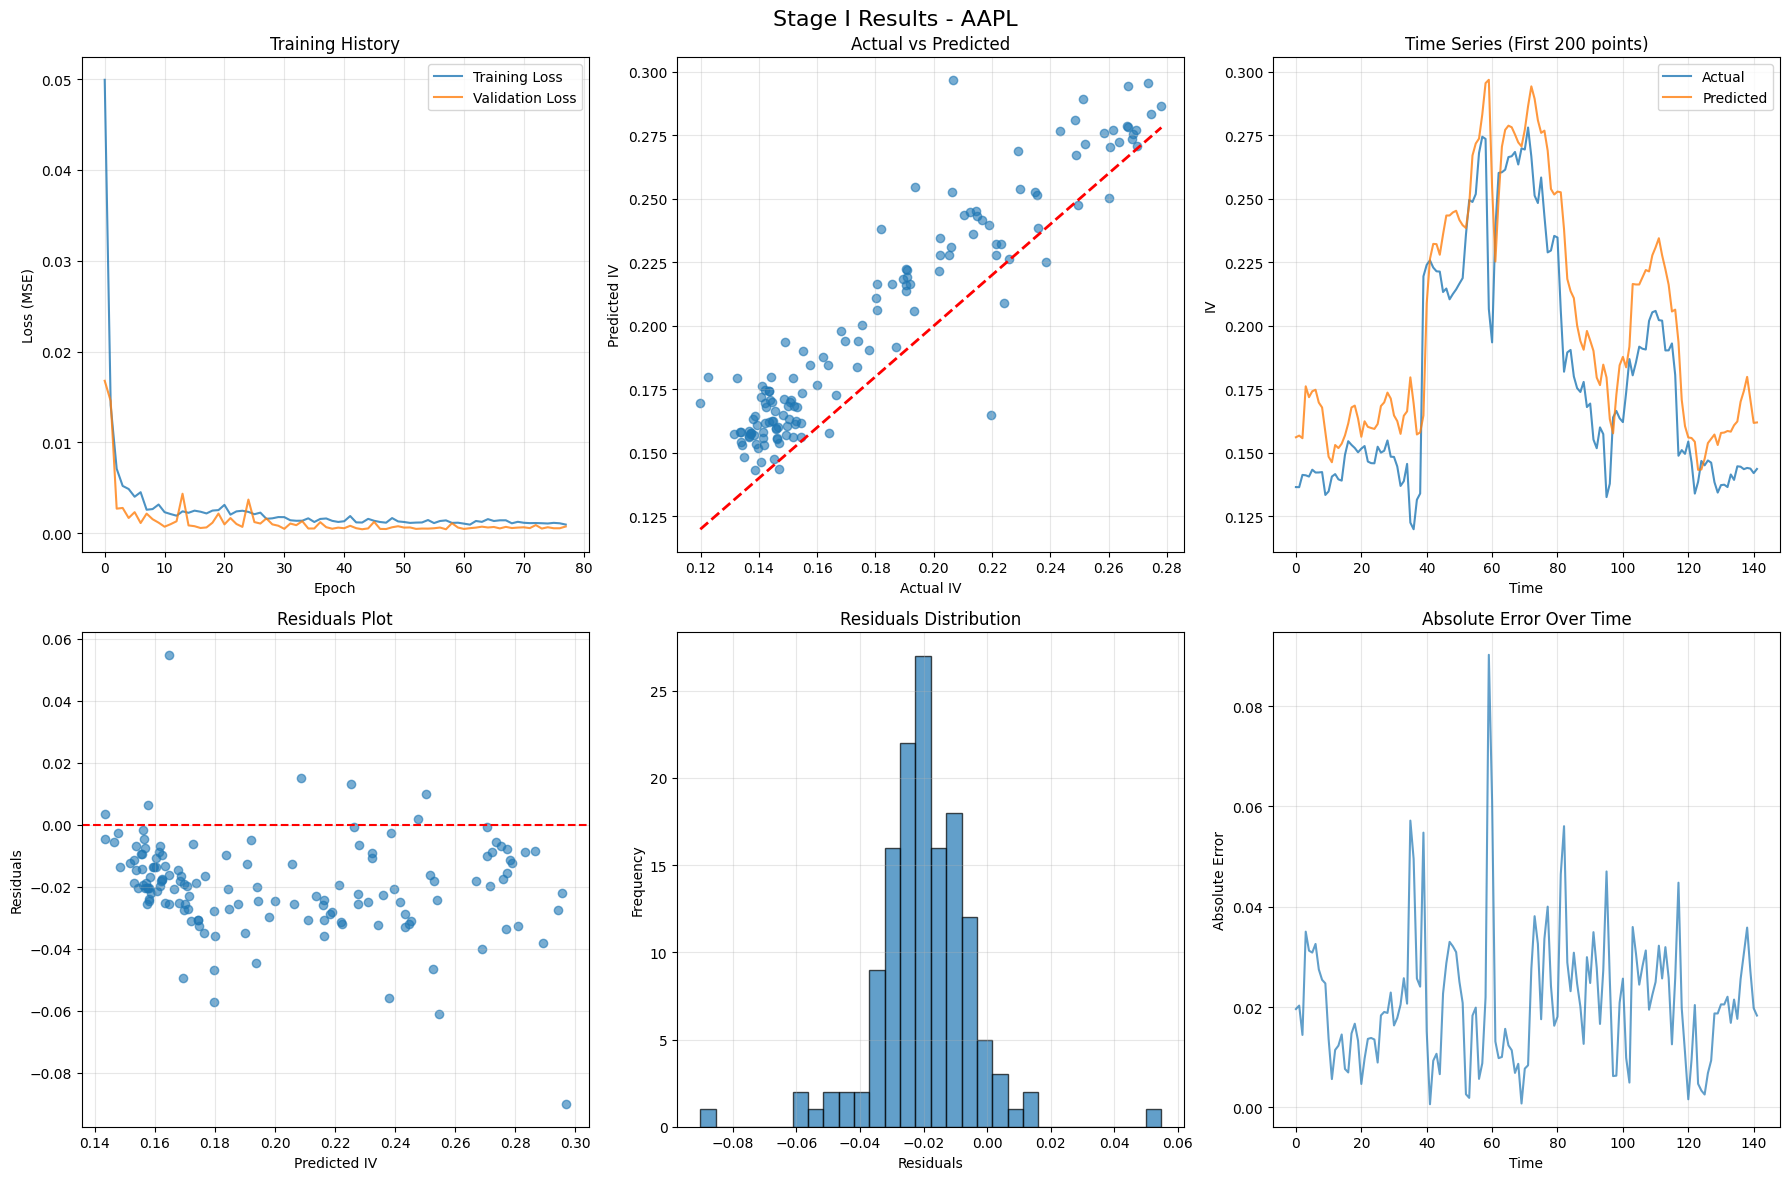

[*********************100%***********************]  1 of 1 completed
[I 2025-07-03 12:55:34,859] A new study created in memory with name: no-name-823f3ad2-b68d-47f7-ab1a-c64949fd3e0b



Processing AMZN...
Optimizing hyperparameters for AMZN...


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [20/50], Train Loss: 0.009430, Val Loss: 0.005444
Epoch [40/50], Train Loss: 0.008003, Val Loss: 0.003269
[I 2025-07-03 12:56:03,224] Trial 0 finished with value: 0.002610122041207635 and parameters: {'hidden_size': 64, 'num_layers': 1, 'dropout_rate': 0.4376934587980793, 'learning_rate': 0.0010924109225195341, 'batch_size': 16}. Best is trial 0 with value: 0.002610122041207635.
Epoch [20/50], Train Loss: 0.008258, Val Loss: 0.008463
Epoch [40/50], Train Loss: 0.004369, Val Loss: 0.002438
[I 2025-07-03 12:58:01,087] Trial 1 finished with value: 0.002438250075404843 and parameters: {'hidden_size': 128, 'num_layers': 2, 'dropout_rate': 0.11280538259819783, 'learning_rate': 0.002510715202094679, 'batch_size': 64}. Best is trial 1 with value: 0.002438250075404843.
Epoch [20/50], Train Loss: 0.009847, Val Loss: 0.005150
[I 2025-07-03 12:58:36,233] Trial 2 finished with value: 0.003180246683768928 and parameters: {'hidden_size': 128, 'num_layers': 1, 'dropout_rate': 0.36909744341231143

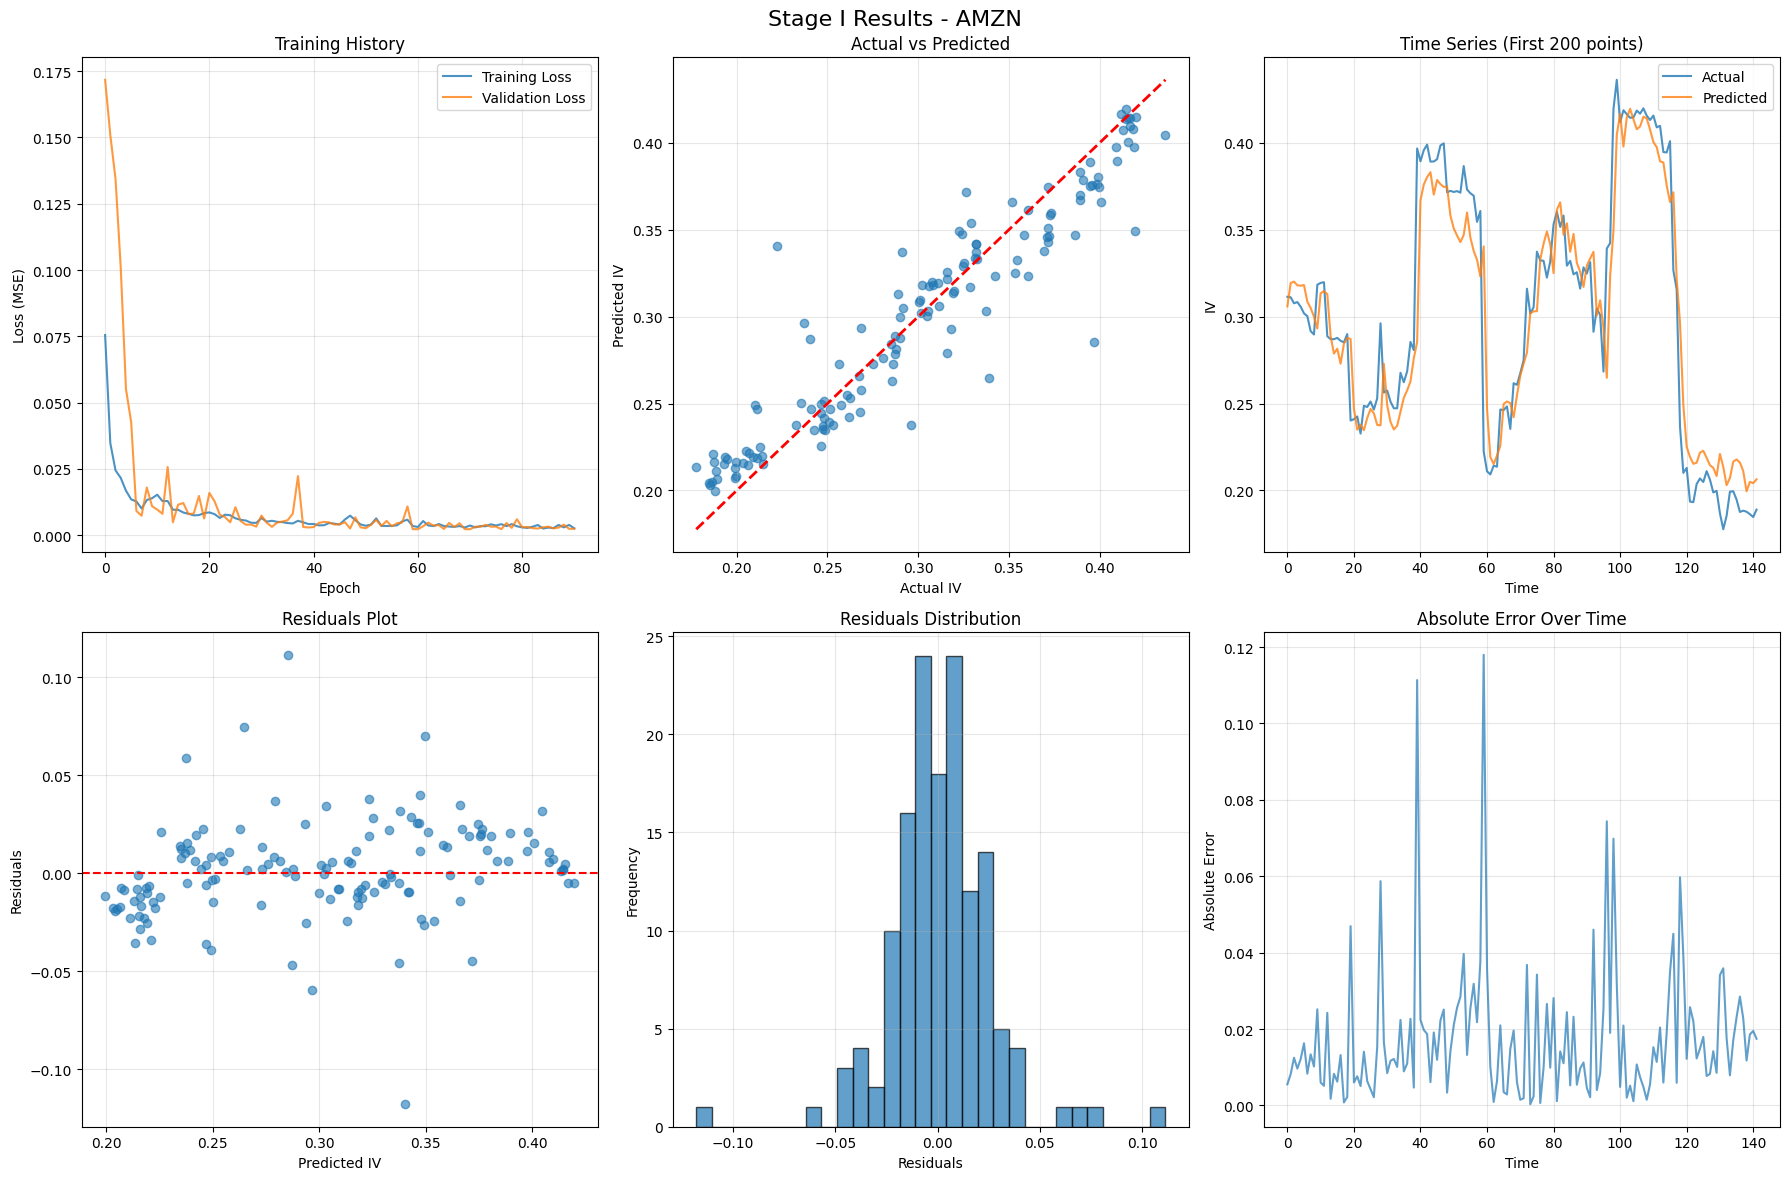

[*********************100%***********************]  1 of 1 completed
[I 2025-07-03 13:04:29,127] A new study created in memory with name: no-name-33a595e6-d382-4a1c-a11a-aa1e5212f361



Processing META...
Optimizing hyperparameters for META...


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [20/50], Train Loss: 0.016594, Val Loss: 0.012380
Epoch [40/50], Train Loss: 0.010834, Val Loss: 0.011358
[I 2025-07-03 13:06:31,999] Trial 0 finished with value: 0.011015163455158471 and parameters: {'hidden_size': 128, 'num_layers': 2, 'dropout_rate': 0.3740604105580181, 'learning_rate': 0.00014776468462283137, 'batch_size': 32}. Best is trial 0 with value: 0.011015163455158471.
Epoch [20/50], Train Loss: 0.010444, Val Loss: 0.016590
Epoch [40/50], Train Loss: 0.006953, Val Loss: 0.009963
[I 2025-07-03 13:08:35,621] Trial 1 finished with value: 0.008134430646896363 and parameters: {'hidden_size': 128, 'num_layers': 2, 'dropout_rate': 0.2736277774939725, 'learning_rate': 0.0003942105890196972, 'batch_size': 32}. Best is trial 1 with value: 0.008134430646896363.
Epoch [20/50], Train Loss: 0.006417, Val Loss: 0.012801
Epoch [40/50], Train Loss: 0.004517, Val Loss: 0.006983
[I 2025-07-03 13:08:56,694] Trial 2 finished with value: 0.005948518868535757 and parameters: {'hidden_size':

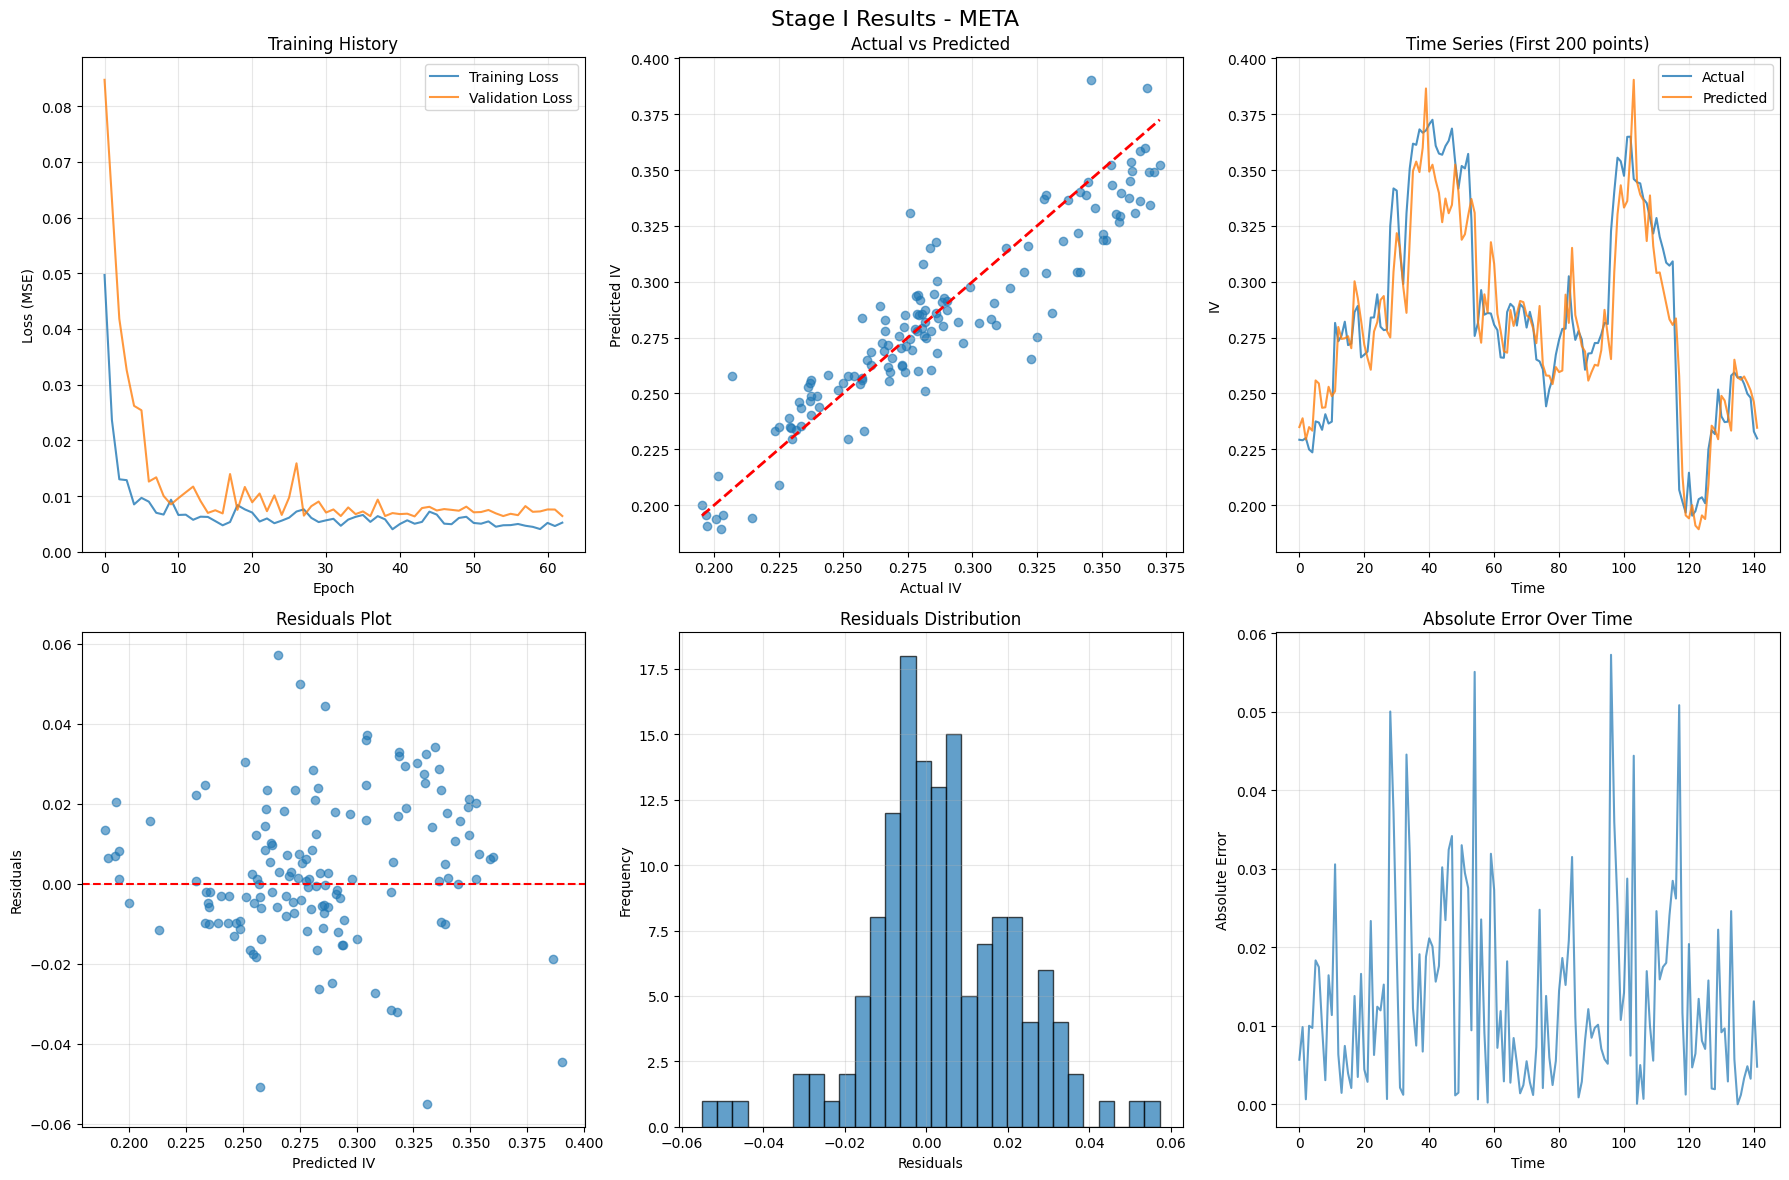

[*********************100%***********************]  1 of 1 completed


Processing AVGO...



[I 2025-07-03 13:11:39,085] A new study created in memory with name: no-name-5db73fc7-0b15-4a12-8746-f807429f915a


Optimizing hyperparameters for AVGO...


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [20/50], Train Loss: 0.002442, Val Loss: 0.001612
Epoch [40/50], Train Loss: 0.002790, Val Loss: 0.012567
[I 2025-07-03 13:12:23,153] Trial 0 finished with value: 0.0009585618681740016 and parameters: {'hidden_size': 64, 'num_layers': 2, 'dropout_rate': 0.1918258445974221, 'learning_rate': 0.008871296729238405, 'batch_size': 32}. Best is trial 0 with value: 0.0009585618681740016.
Epoch [20/50], Train Loss: 0.002255, Val Loss: 0.000683
Epoch [40/50], Train Loss: 0.001496, Val Loss: 0.000500
[I 2025-07-03 13:12:49,557] Trial 1 finished with value: 0.0003918879883713089 and parameters: {'hidden_size': 64, 'num_layers': 1, 'dropout_rate': 0.43444396482285463, 'learning_rate': 0.0030409076628501136, 'batch_size': 16}. Best is trial 1 with value: 0.0003918879883713089.
Epoch [20/50], Train Loss: 0.001140, Val Loss: 0.001698
Epoch [40/50], Train Loss: 0.000697, Val Loss: 0.000838
[I 2025-07-03 13:13:41,716] Trial 2 finished with value: 0.0007581474395313611 and parameters: {'hidden_size

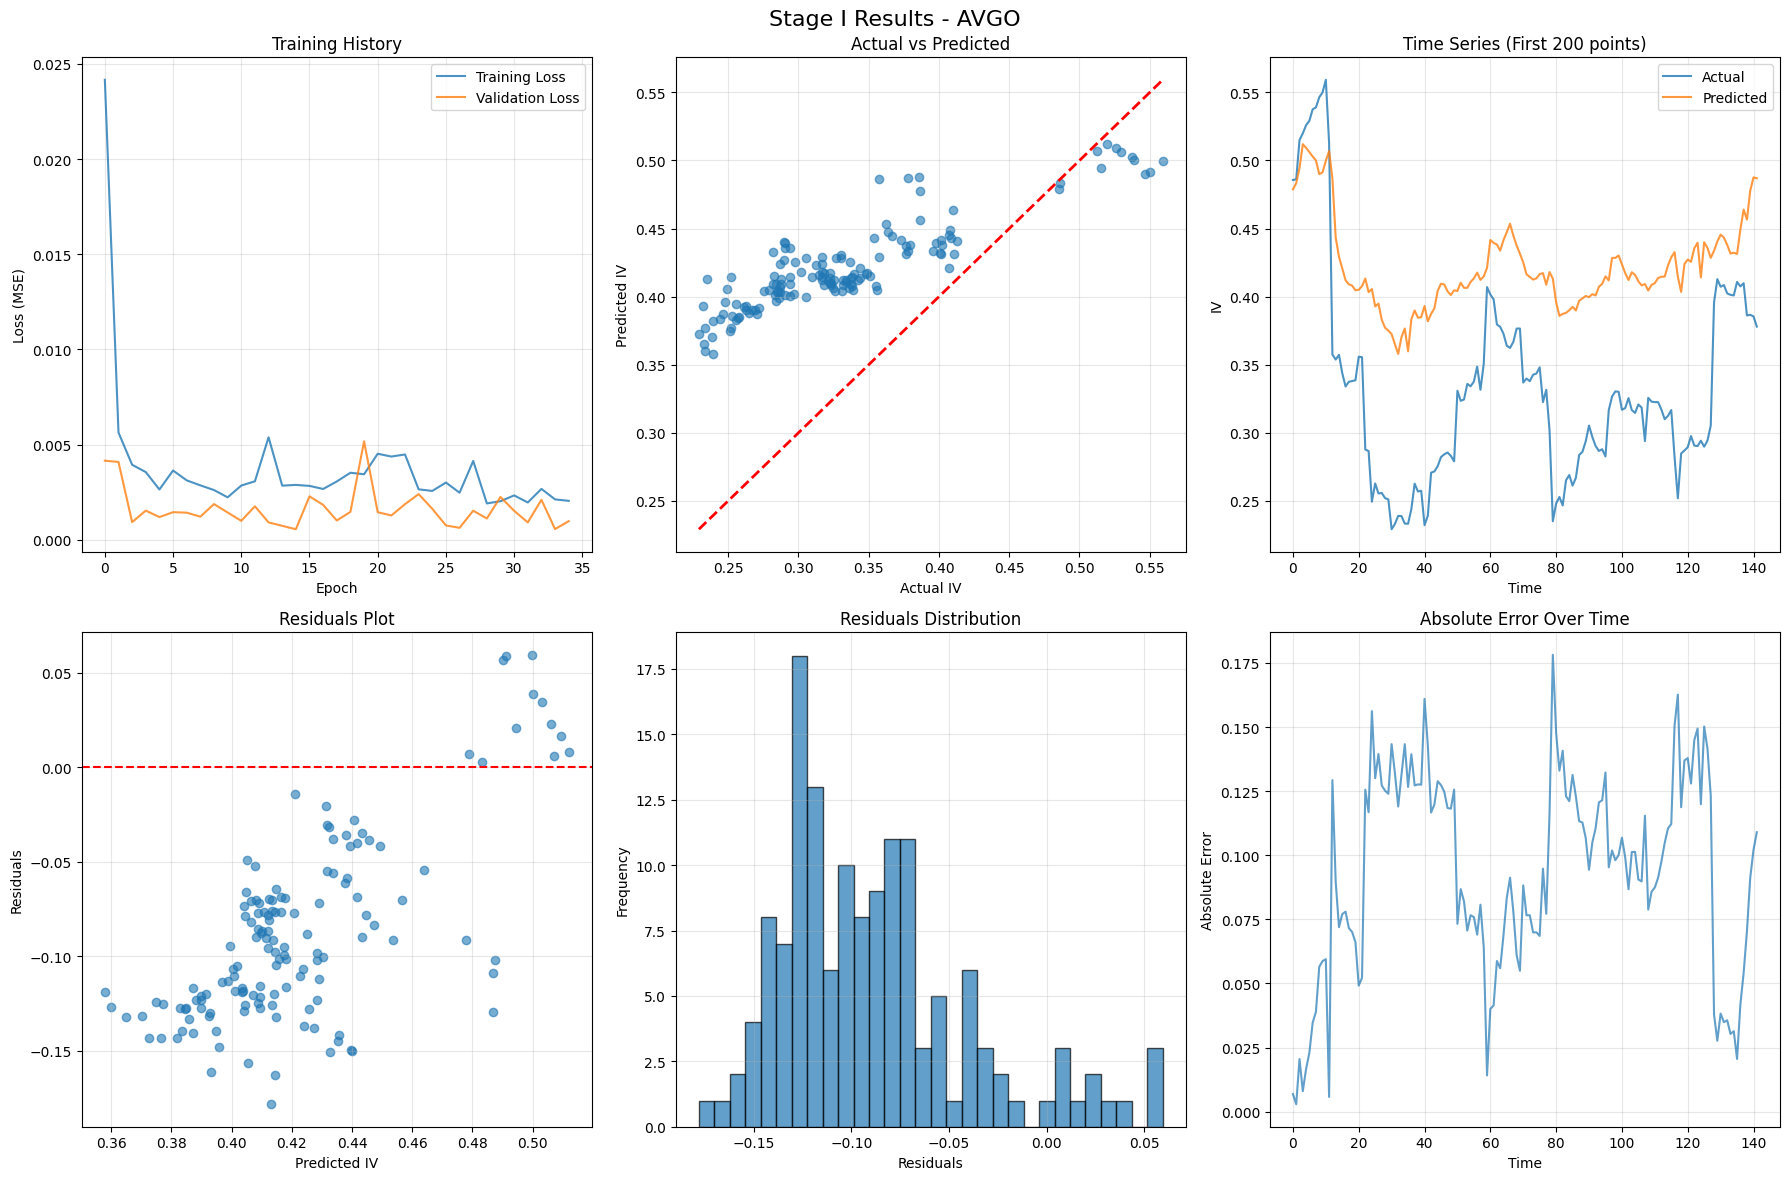

[*********************100%***********************]  1 of 1 completed
[I 2025-07-03 13:17:50,221] A new study created in memory with name: no-name-44cc3c0b-6bdc-46da-b47d-4dd405ac008f



Processing TSLA...
Optimizing hyperparameters for TSLA...


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [20/50], Train Loss: 0.005153, Val Loss: 0.001266
Epoch [40/50], Train Loss: 0.003338, Val Loss: 0.001145
[I 2025-07-03 13:19:53,318] Trial 0 finished with value: 0.0007313477806746959 and parameters: {'hidden_size': 128, 'num_layers': 2, 'dropout_rate': 0.4152083880319716, 'learning_rate': 0.0012590549792967287, 'batch_size': 32}. Best is trial 0 with value: 0.0007313477806746959.
Epoch [20/50], Train Loss: 0.003959, Val Loss: 0.001980
Epoch [40/50], Train Loss: 0.002528, Val Loss: 0.000935
[I 2025-07-03 13:20:14,264] Trial 1 finished with value: 0.0005764461141855767 and parameters: {'hidden_size': 64, 'num_layers': 1, 'dropout_rate': 0.15123275870199177, 'learning_rate': 0.0018641629215824962, 'batch_size': 64}. Best is trial 1 with value: 0.0005764461141855767.
Epoch [20/50], Train Loss: 0.007538, Val Loss: 0.005216
Epoch [40/50], Train Loss: 0.004744, Val Loss: 0.002765
[I 2025-07-03 13:22:17,771] Trial 2 finished with value: 0.0014255854941438884 and parameters: {'hidden_si

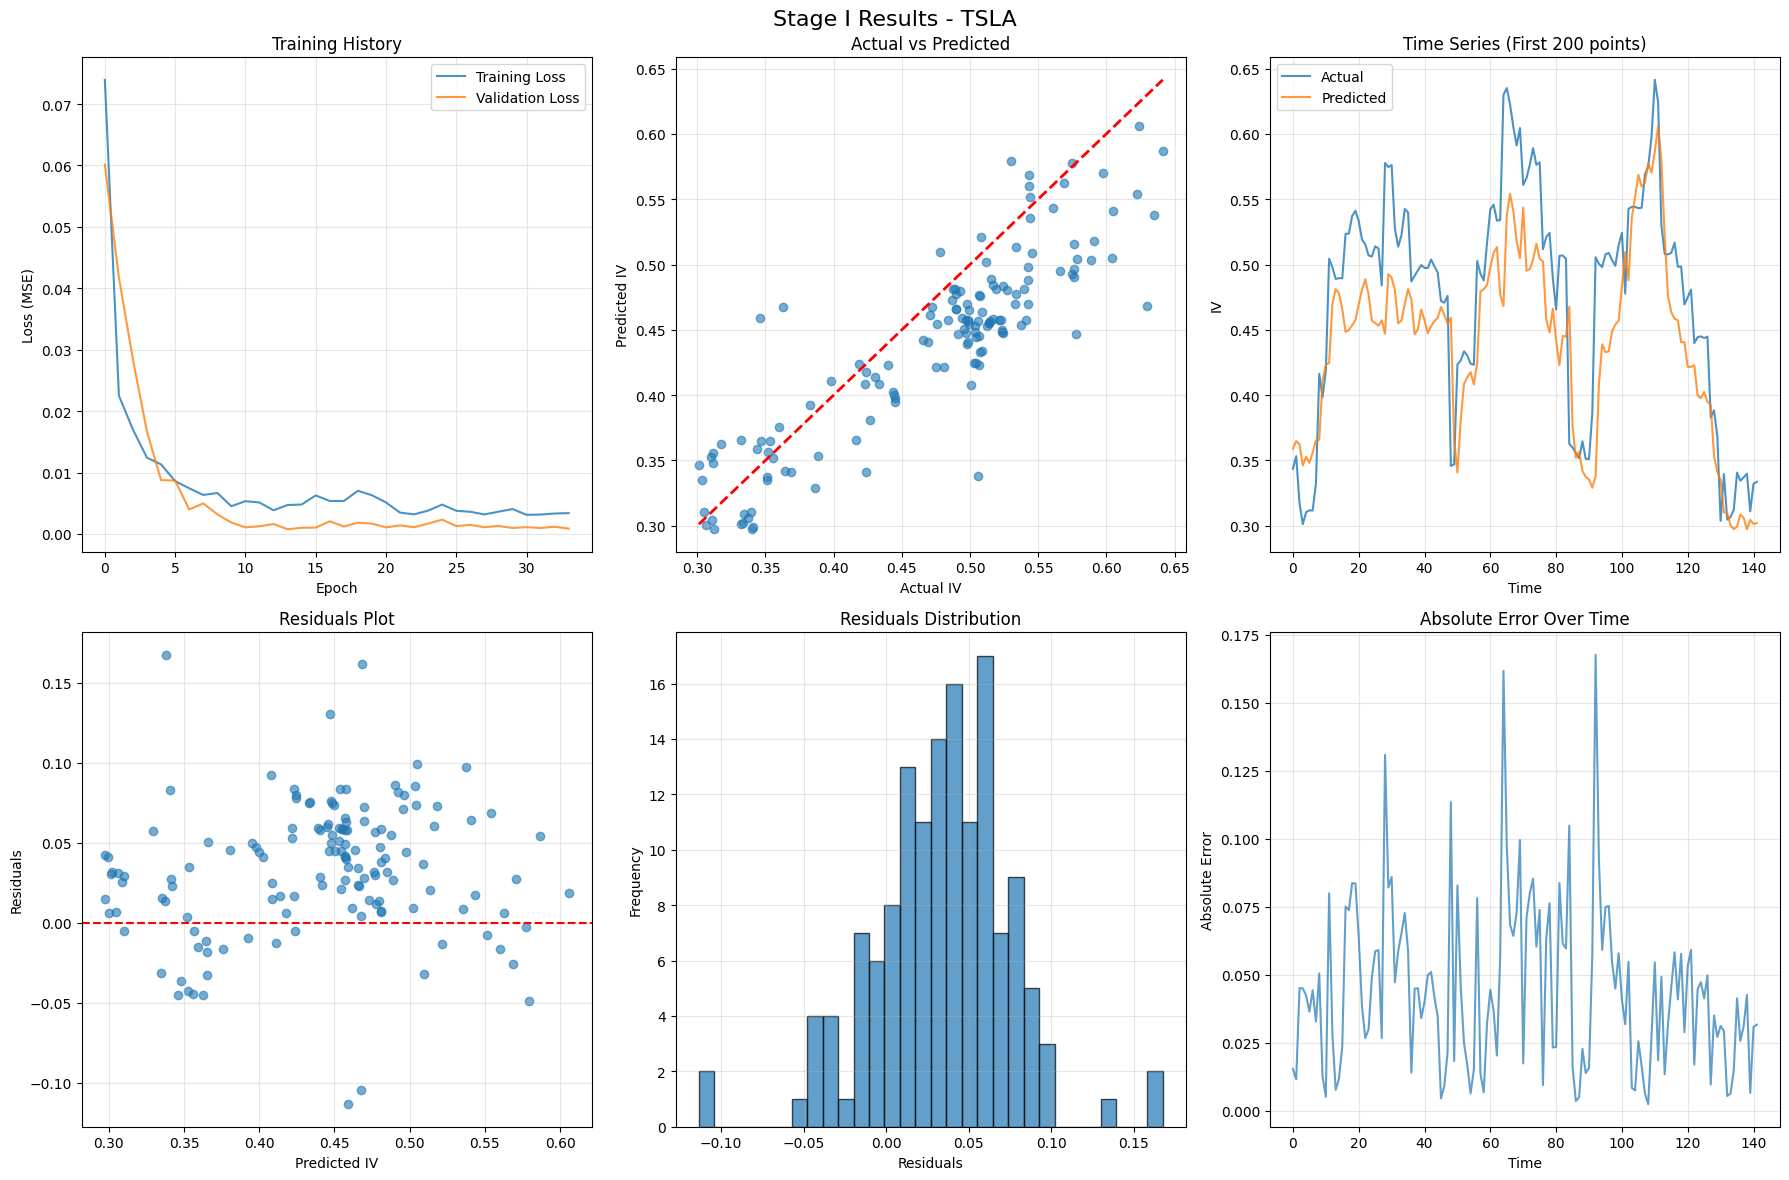

[*********************100%***********************]  1 of 1 completed
[I 2025-07-03 13:27:29,574] A new study created in memory with name: no-name-eacb6794-2f77-4caf-9631-dba158ce7b18



Processing GOOGL...
Optimizing hyperparameters for GOOGL...


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [20/50], Train Loss: 0.003880, Val Loss: 0.001943
Epoch [40/50], Train Loss: 0.003113, Val Loss: 0.001164
[I 2025-07-03 13:28:25,421] Trial 0 finished with value: 0.0010466055149057258 and parameters: {'hidden_size': 128, 'num_layers': 1, 'dropout_rate': 0.41410942735324197, 'learning_rate': 0.0008383680878991224, 'batch_size': 16}. Best is trial 0 with value: 0.0010466055149057258.
Epoch [20/50], Train Loss: 0.003514, Val Loss: 0.001374
Epoch [40/50], Train Loss: 0.002976, Val Loss: 0.001801
[I 2025-07-03 13:28:48,678] Trial 1 finished with value: 0.0009792016062419862 and parameters: {'hidden_size': 64, 'num_layers': 1, 'dropout_rate': 0.3204869483693127, 'learning_rate': 0.0016892504277257986, 'batch_size': 32}. Best is trial 1 with value: 0.0009792016062419862.
Epoch [20/50], Train Loss: 0.002861, Val Loss: 0.001114
Epoch [40/50], Train Loss: 0.001915, Val Loss: 0.001289
[I 2025-07-03 13:29:40,180] Trial 2 finished with value: 0.0009736239444464445 and parameters: {'hidden_si

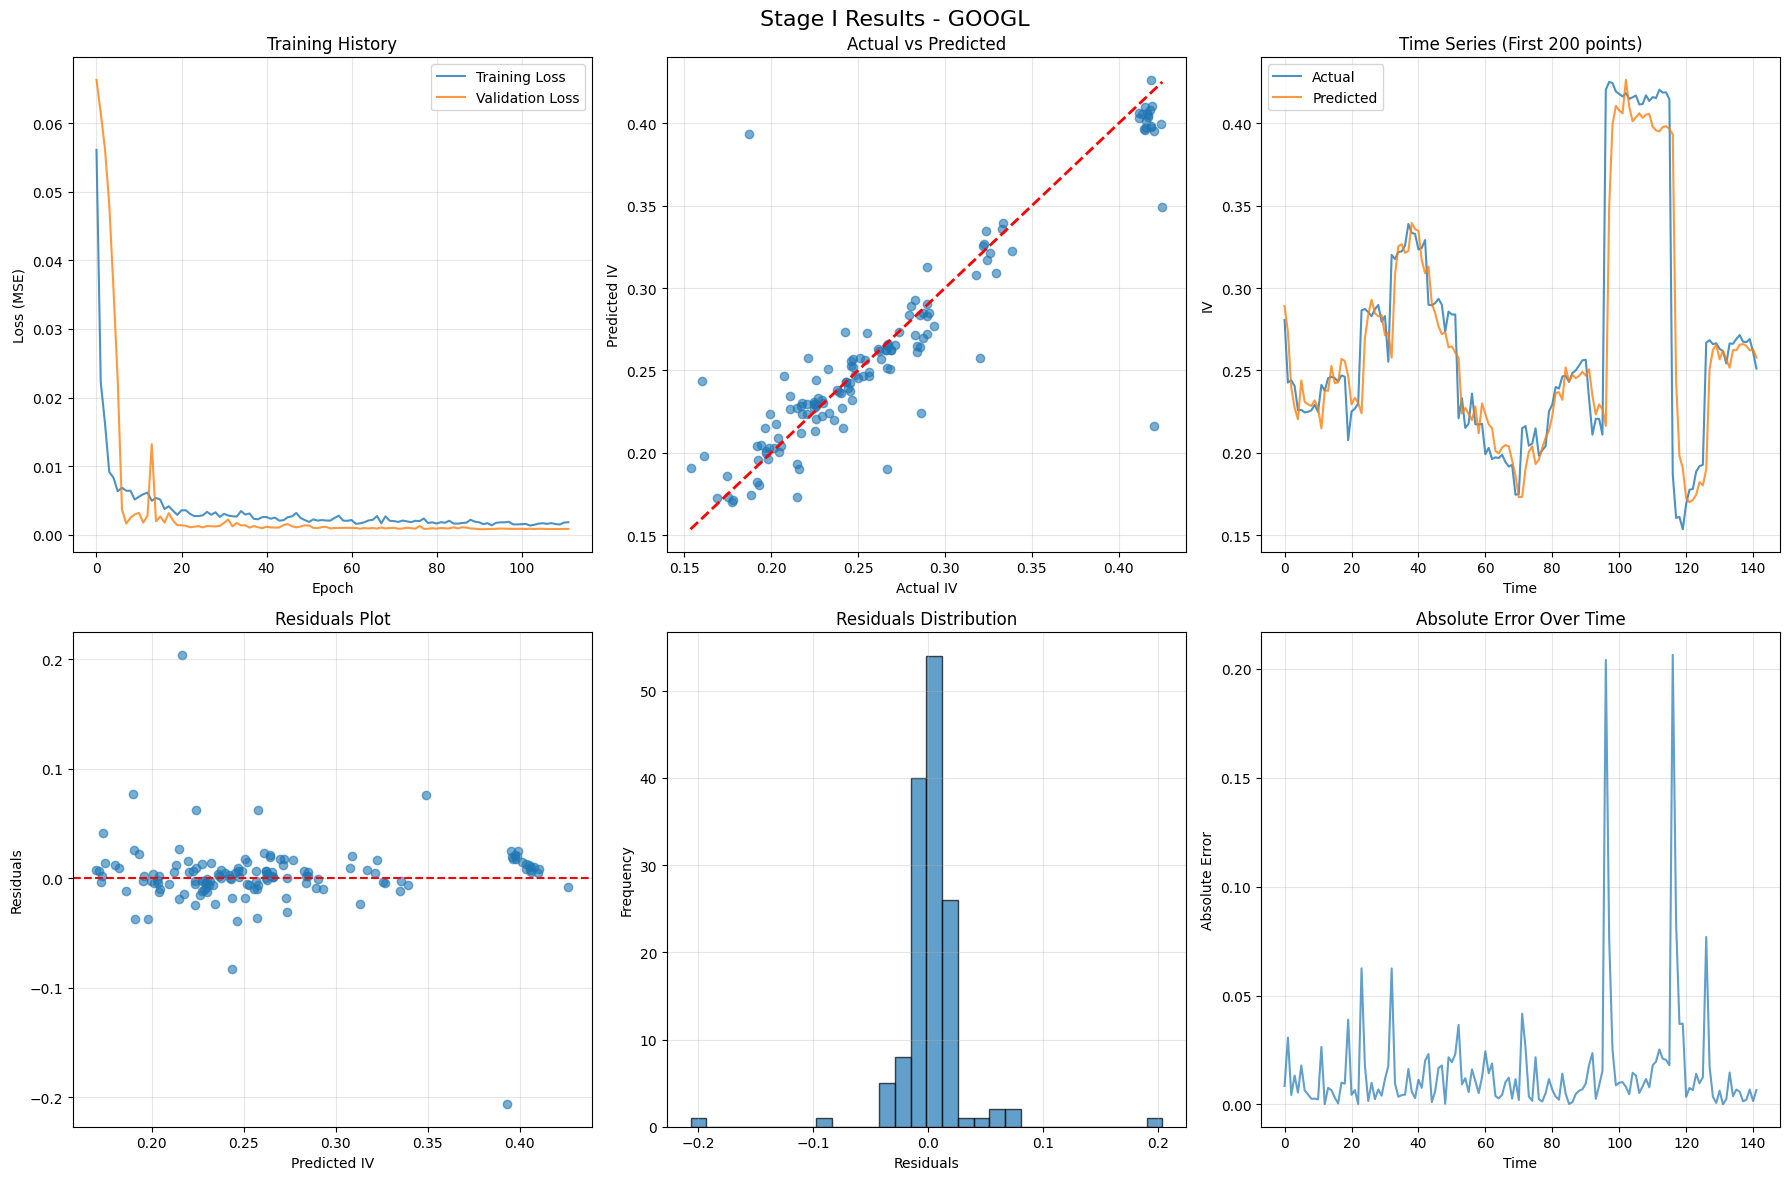

[*********************100%***********************]  1 of 1 completed
[I 2025-07-03 13:34:19,312] A new study created in memory with name: no-name-45c9842e-0ed1-49b8-89c6-1ef82056839a



Processing HD...
Optimizing hyperparameters for HD...


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [20/50], Train Loss: 0.002708, Val Loss: 0.001033
Epoch [40/50], Train Loss: 0.002082, Val Loss: 0.000987
[I 2025-07-03 13:34:43,014] Trial 0 finished with value: 0.0003454973455518484 and parameters: {'hidden_size': 64, 'num_layers': 1, 'dropout_rate': 0.32998441972892023, 'learning_rate': 0.0010575241621298475, 'batch_size': 32}. Best is trial 0 with value: 0.0003454973455518484.
Epoch [20/50], Train Loss: 0.001853, Val Loss: 0.000824
Epoch [40/50], Train Loss: 0.001035, Val Loss: 0.000489
[I 2025-07-03 13:35:34,470] Trial 1 finished with value: 0.000435066205682233 and parameters: {'hidden_size': 128, 'num_layers': 1, 'dropout_rate': 0.11882932642876219, 'learning_rate': 0.0003000202452607695, 'batch_size': 32}. Best is trial 0 with value: 0.0003454973455518484.
Epoch [20/50], Train Loss: 0.001462, Val Loss: 0.001549
Epoch [40/50], Train Loss: 0.001729, Val Loss: 0.001107
[I 2025-07-03 13:37:35,827] Trial 2 finished with value: 0.0006364677946193195 and parameters: {'hidden_si

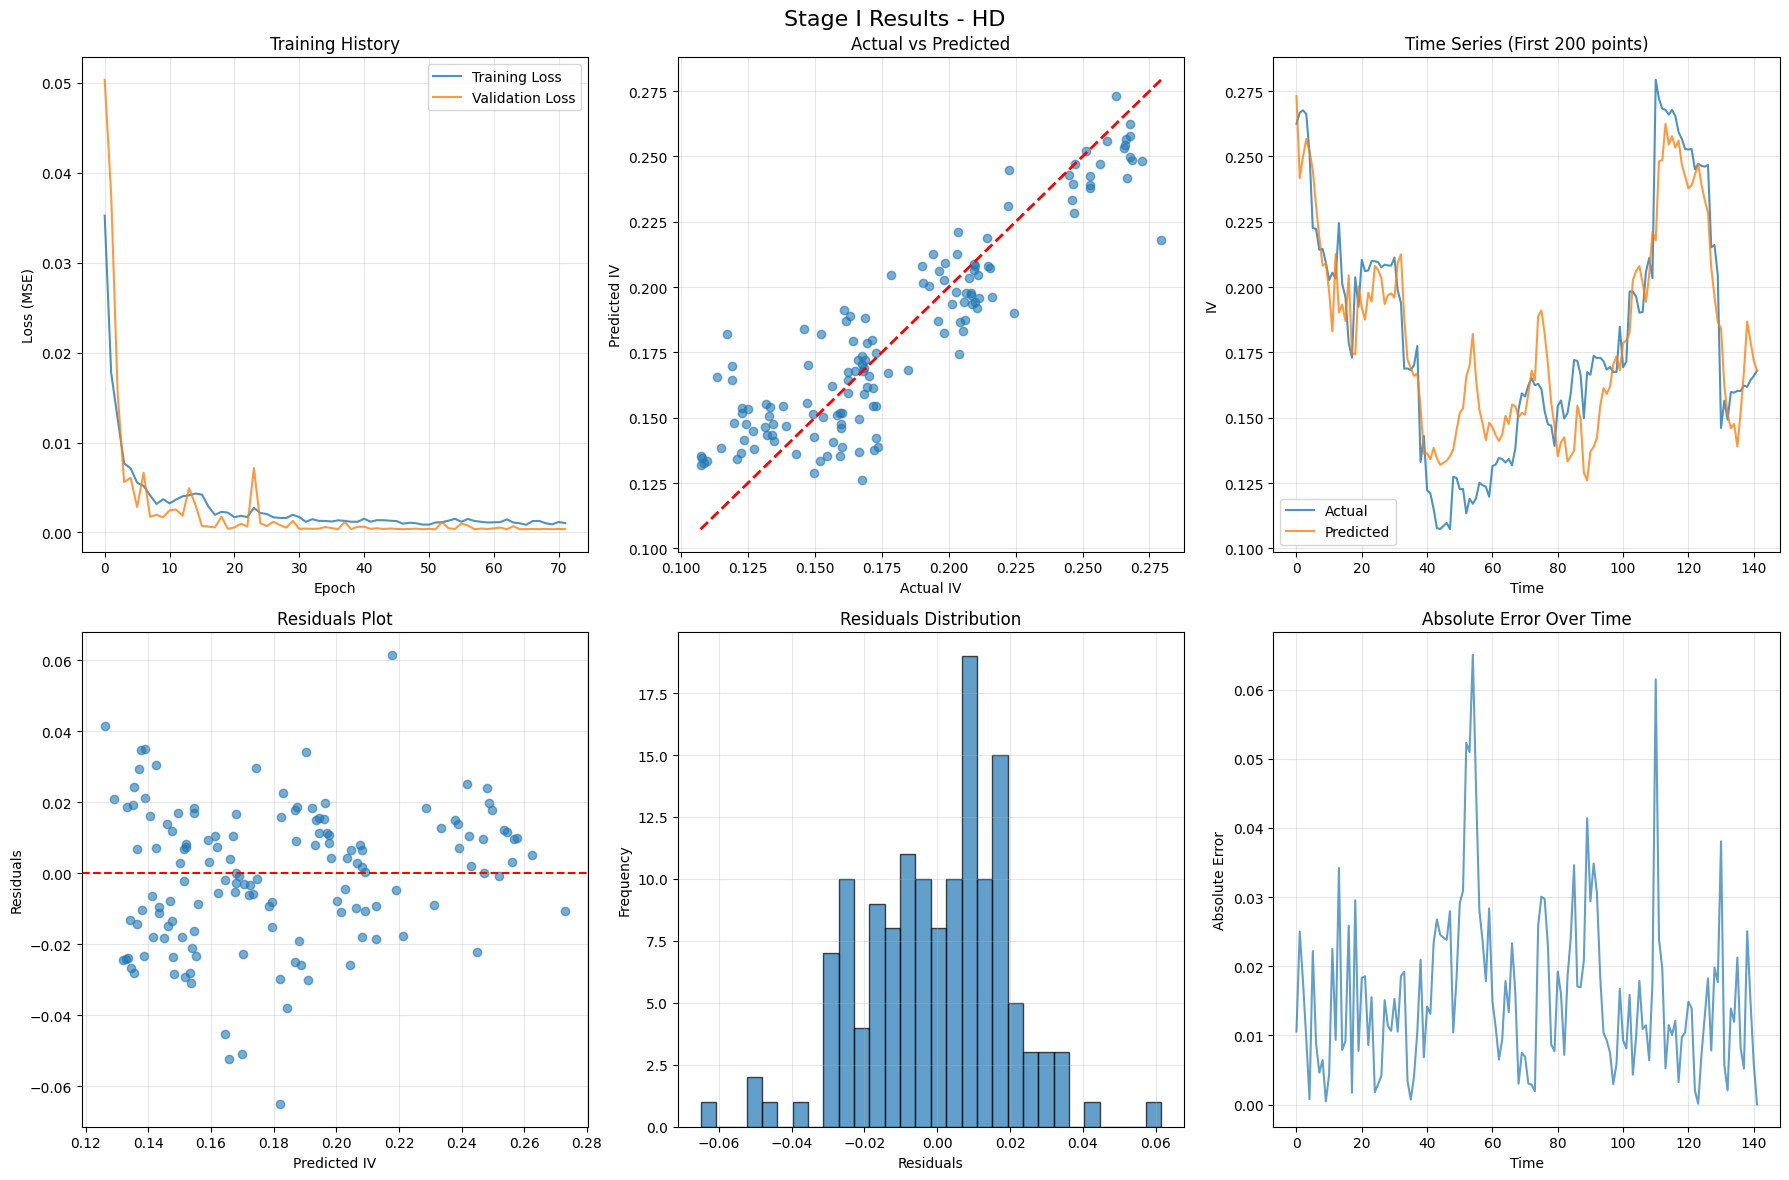

[*********************100%***********************]  1 of 1 completed
[I 2025-07-03 13:40:28,519] A new study created in memory with name: no-name-0226014b-26ec-4391-9584-ae6ab0fc3c26



Processing GOOG...
Optimizing hyperparameters for GOOG...


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [20/50], Train Loss: 0.005420, Val Loss: 0.002328
Epoch [40/50], Train Loss: 0.004433, Val Loss: 0.002035
[I 2025-07-03 13:42:29,868] Trial 0 finished with value: 0.001724484991023524 and parameters: {'hidden_size': 128, 'num_layers': 2, 'dropout_rate': 0.18974634003431057, 'learning_rate': 0.00029811394909685663, 'batch_size': 16}. Best is trial 0 with value: 0.001724484991023524.
Epoch [20/50], Train Loss: 0.006636, Val Loss: 0.003150
Epoch [40/50], Train Loss: 0.004600, Val Loss: 0.002620
[I 2025-07-03 13:43:22,462] Trial 1 finished with value: 0.0018583112072923945 and parameters: {'hidden_size': 64, 'num_layers': 2, 'dropout_rate': 0.4384329938846445, 'learning_rate': 0.0008459683580197203, 'batch_size': 16}. Best is trial 0 with value: 0.001724484991023524.
Epoch [20/50], Train Loss: 0.003988, Val Loss: 0.001525
Epoch [40/50], Train Loss: 0.002879, Val Loss: 0.001666
[I 2025-07-03 13:43:42,977] Trial 2 finished with value: 0.0010237494425382465 and parameters: {'hidden_size

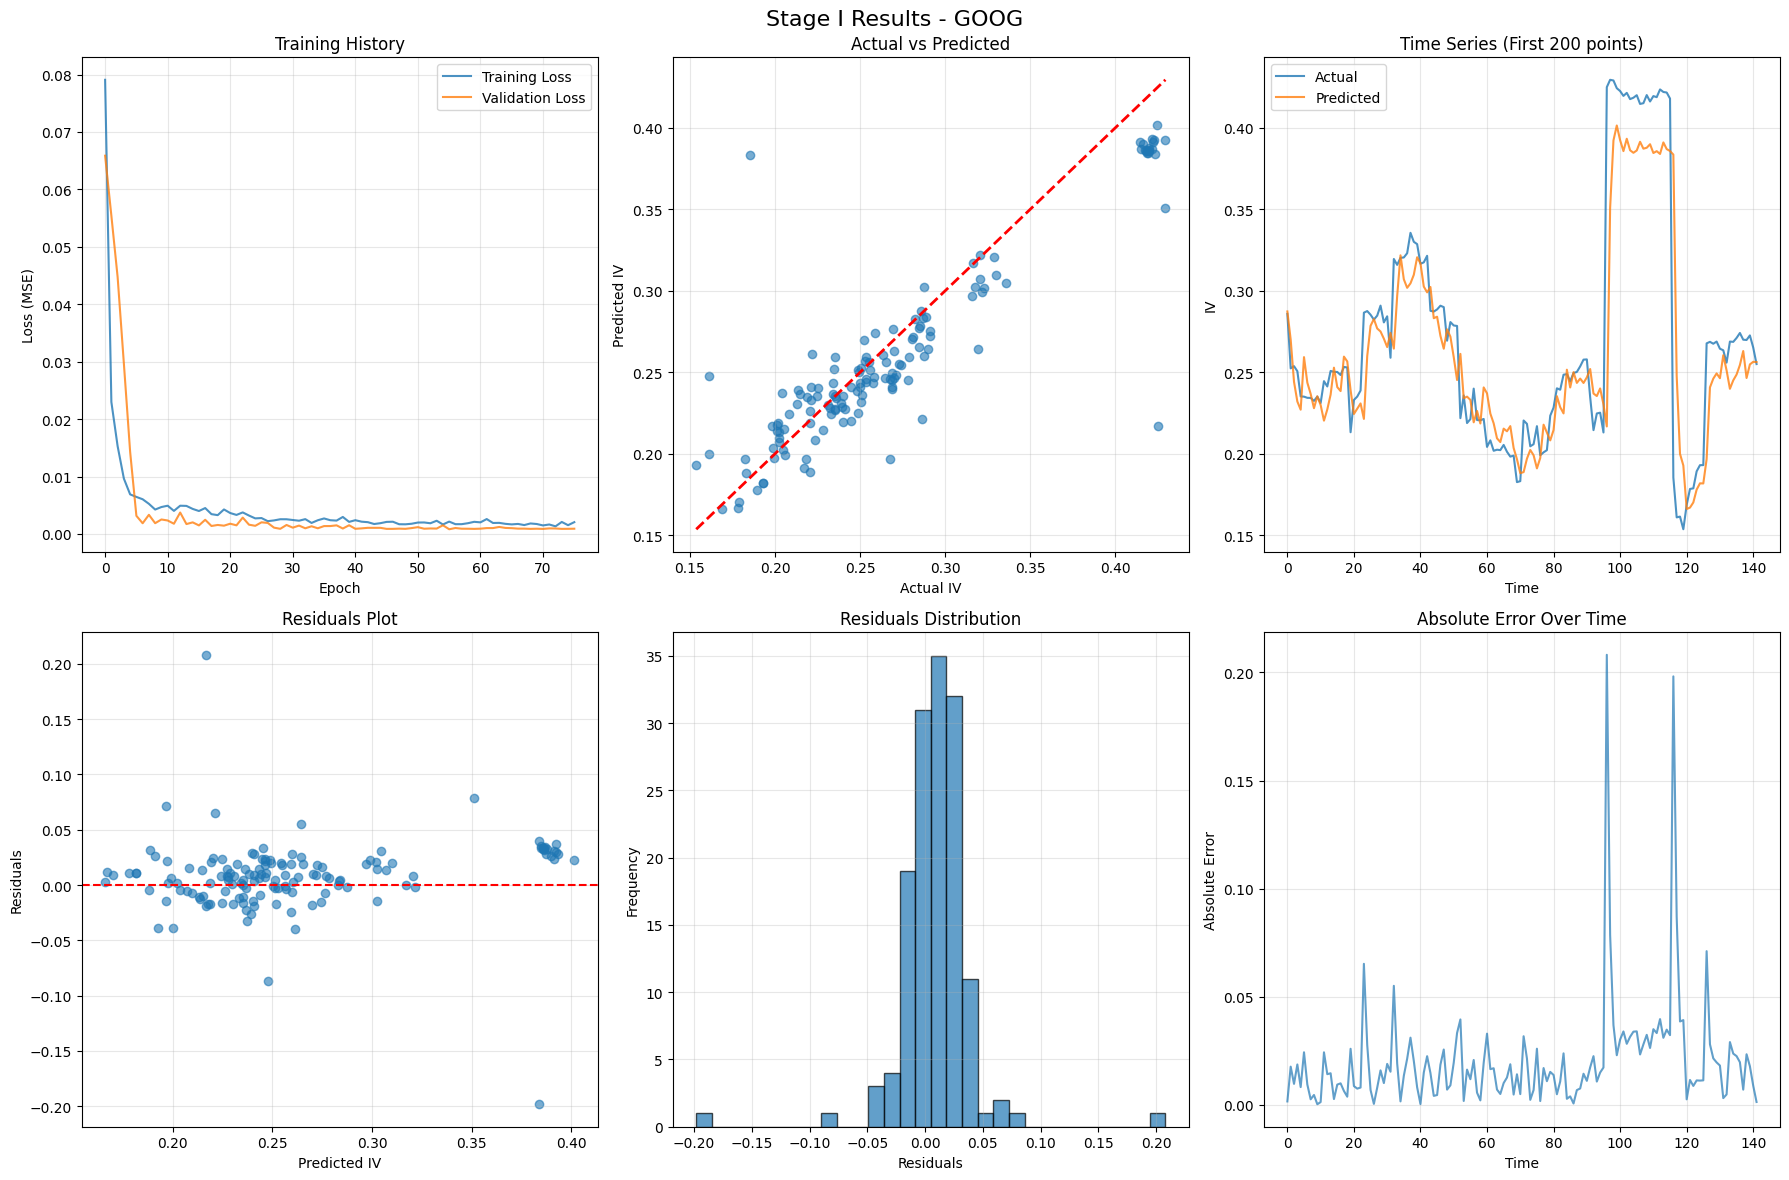

[*********************100%***********************]  1 of 1 completed
[I 2025-07-03 13:47:14,847] A new study created in memory with name: no-name-f743572a-269f-4d96-88b7-1d108ca05153



Processing JPM...
Optimizing hyperparameters for JPM...


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [20/50], Train Loss: 0.002713, Val Loss: 0.000781
[I 2025-07-03 13:48:00,469] Trial 0 finished with value: 0.0005846881564745369 and parameters: {'hidden_size': 128, 'num_layers': 1, 'dropout_rate': 0.44581767553534835, 'learning_rate': 0.0006621530011449641, 'batch_size': 16}. Best is trial 0 with value: 0.0005846881564745369.
Epoch [20/50], Train Loss: 0.002848, Val Loss: 0.002096
[I 2025-07-03 13:48:24,754] Trial 1 finished with value: 0.001352438020856223 and parameters: {'hidden_size': 64, 'num_layers': 2, 'dropout_rate': 0.36415184272570034, 'learning_rate': 0.0015858924780379376, 'batch_size': 16}. Best is trial 0 with value: 0.0005846881564745369.
Epoch [20/50], Train Loss: 0.003007, Val Loss: 0.000828
[I 2025-07-03 13:49:05,540] Trial 2 finished with value: 0.0005889316946397432 and parameters: {'hidden_size': 128, 'num_layers': 1, 'dropout_rate': 0.3465156274521415, 'learning_rate': 0.000367290667158033, 'batch_size': 16}. Best is trial 0 with value: 0.00058468815647453

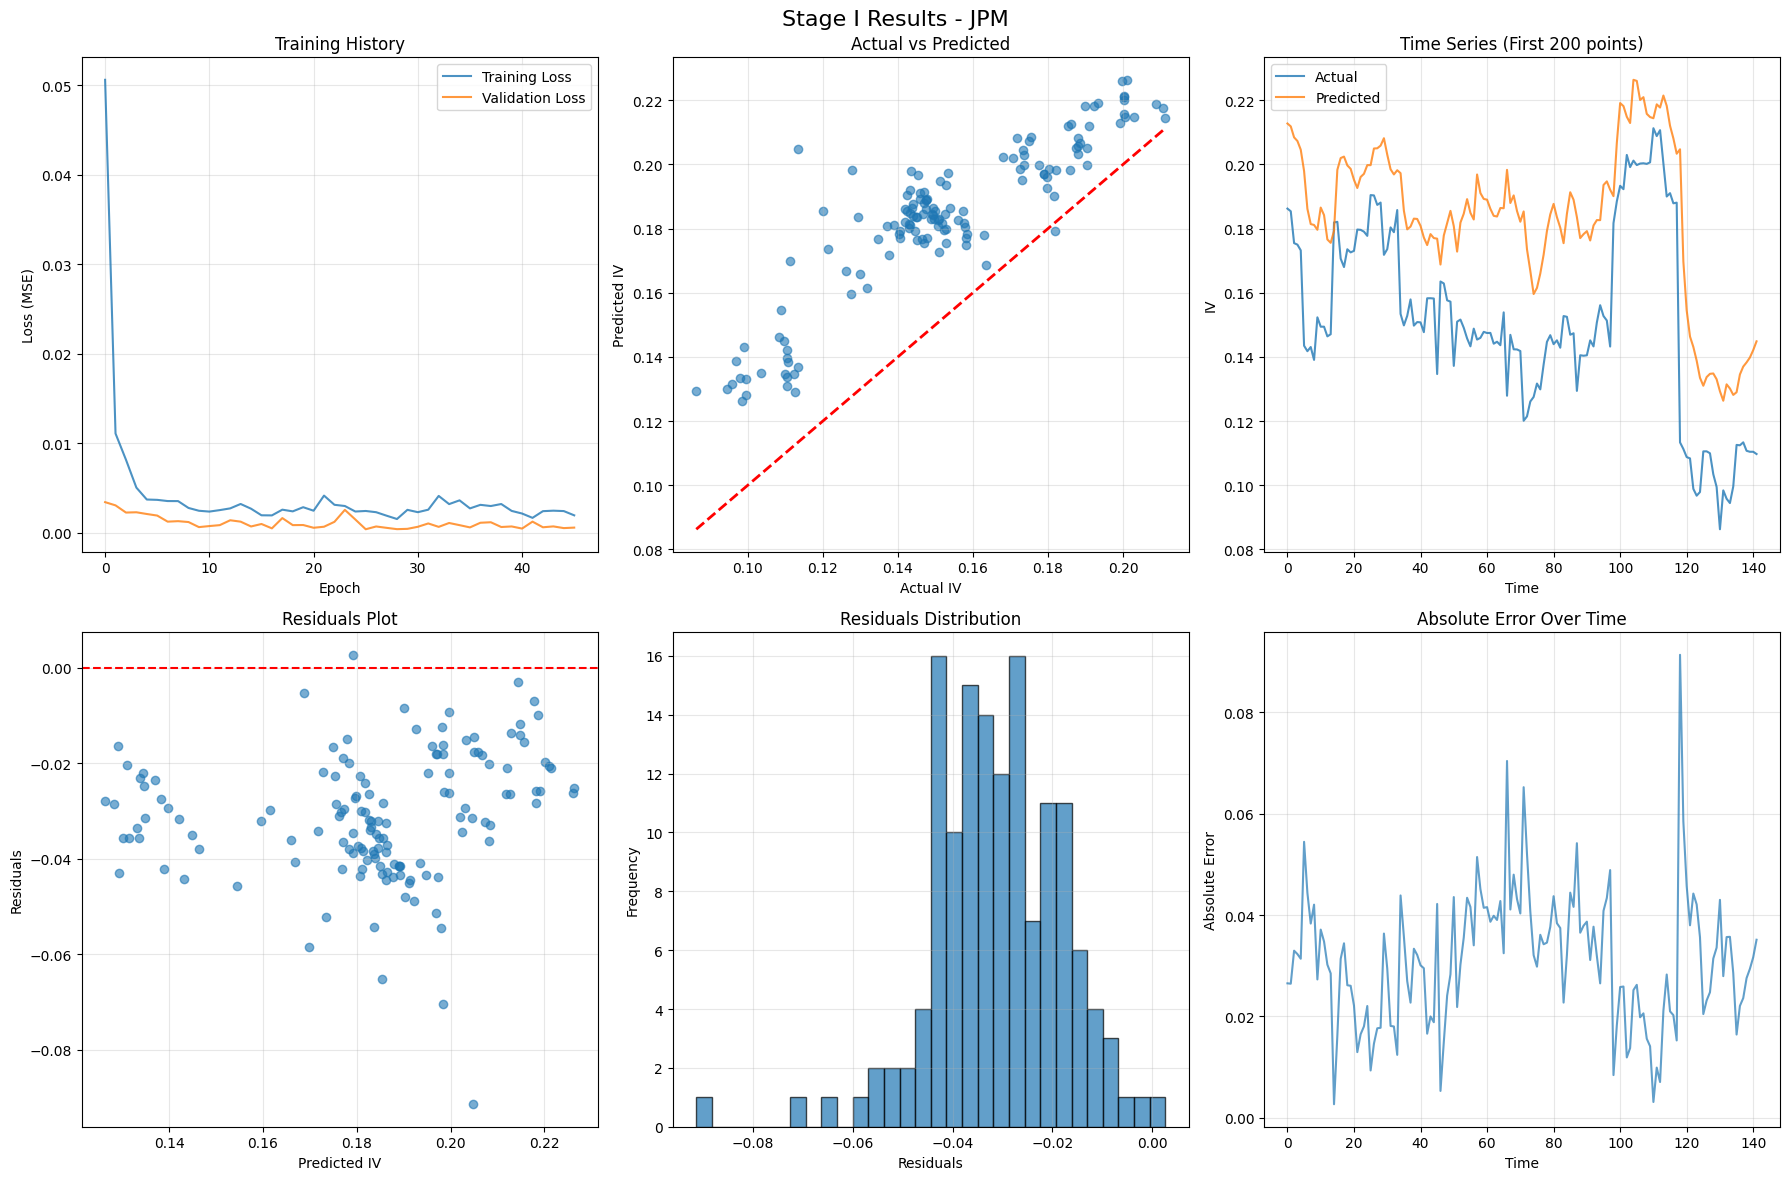

[*********************100%***********************]  1 of 1 completed
[I 2025-07-03 13:50:58,119] A new study created in memory with name: no-name-3e4f44dc-d92f-40b3-a26d-263881bf8f3e



Processing WMT...
Optimizing hyperparameters for WMT...


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [20/50], Train Loss: 0.003411, Val Loss: 0.001926
[I 2025-07-03 13:51:12,452] Trial 0 finished with value: 0.0005623189761536195 and parameters: {'hidden_size': 64, 'num_layers': 1, 'dropout_rate': 0.4598911451053532, 'learning_rate': 0.00181590680373447, 'batch_size': 32}. Best is trial 0 with value: 0.0005623189761536195.
Epoch [20/50], Train Loss: 0.003536, Val Loss: 0.000625
Epoch [40/50], Train Loss: 0.002435, Val Loss: 0.000708
[I 2025-07-03 13:51:33,553] Trial 1 finished with value: 0.000487305034766905 and parameters: {'hidden_size': 64, 'num_layers': 1, 'dropout_rate': 0.37969337330230224, 'learning_rate': 0.003418920880916761, 'batch_size': 32}. Best is trial 1 with value: 0.000487305034766905.
Epoch [20/50], Train Loss: 0.003328, Val Loss: 0.016632
Epoch [40/50], Train Loss: 0.002353, Val Loss: 0.001125
[I 2025-07-03 13:52:19,859] Trial 2 finished with value: 0.0005603253949731071 and parameters: {'hidden_size': 128, 'num_layers': 1, 'dropout_rate': 0.37764741490812026

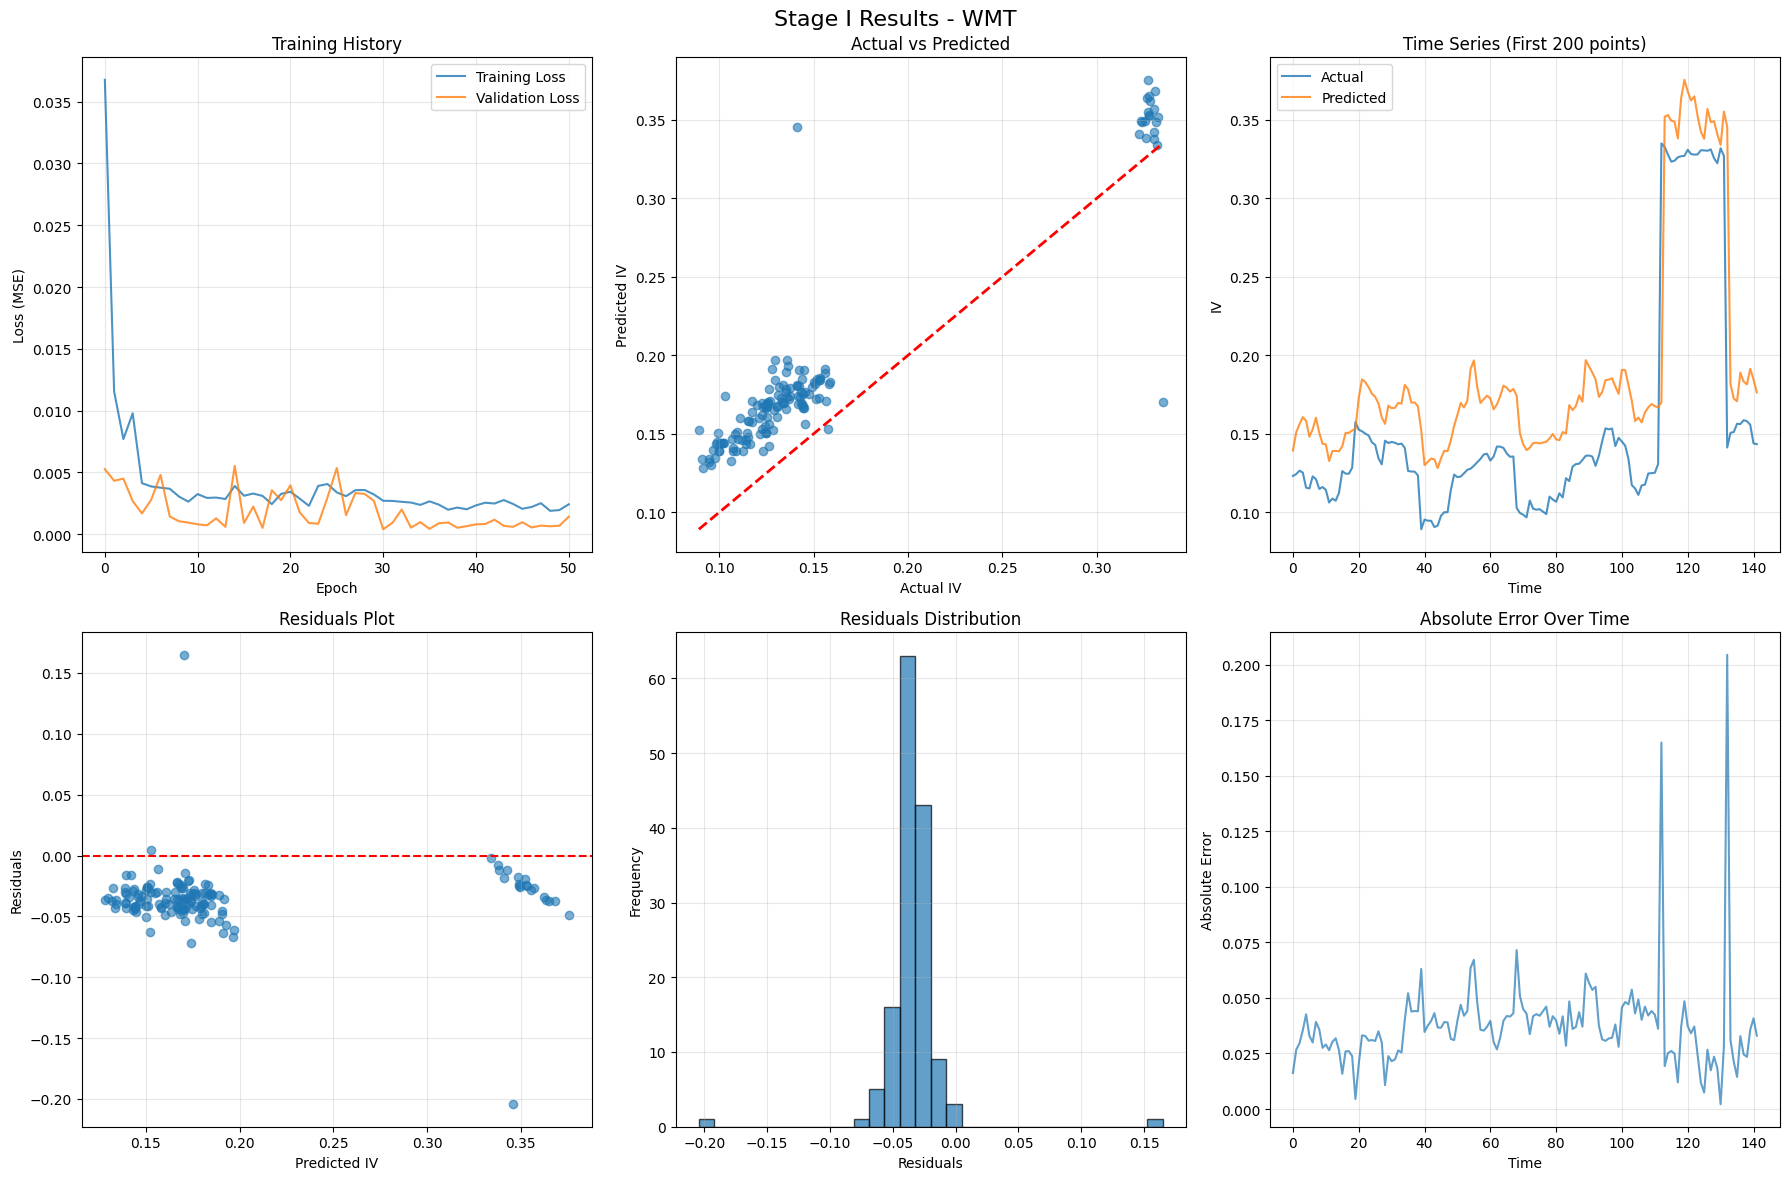

[*********************100%***********************]  1 of 1 completed
[I 2025-07-03 13:55:35,327] A new study created in memory with name: no-name-30a34050-1c95-4d19-b377-a96daa6cb380



Processing LLY...
Optimizing hyperparameters for LLY...


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [20/50], Train Loss: 0.007092, Val Loss: 0.001621
Epoch [40/50], Train Loss: 0.004046, Val Loss: 0.002087
[I 2025-07-03 13:56:21,255] Trial 0 finished with value: 0.0010347578208893538 and parameters: {'hidden_size': 64, 'num_layers': 2, 'dropout_rate': 0.3974516212968088, 'learning_rate': 0.001612363887315345, 'batch_size': 32}. Best is trial 0 with value: 0.0010347578208893538.
Epoch [20/50], Train Loss: 0.013228, Val Loss: 0.005050
Epoch [40/50], Train Loss: 0.006855, Val Loss: 0.002190
[I 2025-07-03 13:58:24,460] Trial 1 finished with value: 0.0014974072226323187 and parameters: {'hidden_size': 128, 'num_layers': 2, 'dropout_rate': 0.28451571684396165, 'learning_rate': 0.00020112676964148036, 'batch_size': 32}. Best is trial 0 with value: 0.0010347578208893538.
Epoch [20/50], Train Loss: 0.003677, Val Loss: 0.001392
Epoch [40/50], Train Loss: 0.003024, Val Loss: 0.001876
[I 2025-07-03 14:00:32,029] Trial 2 finished with value: 0.0008610963510970274 and parameters: {'hidden_si

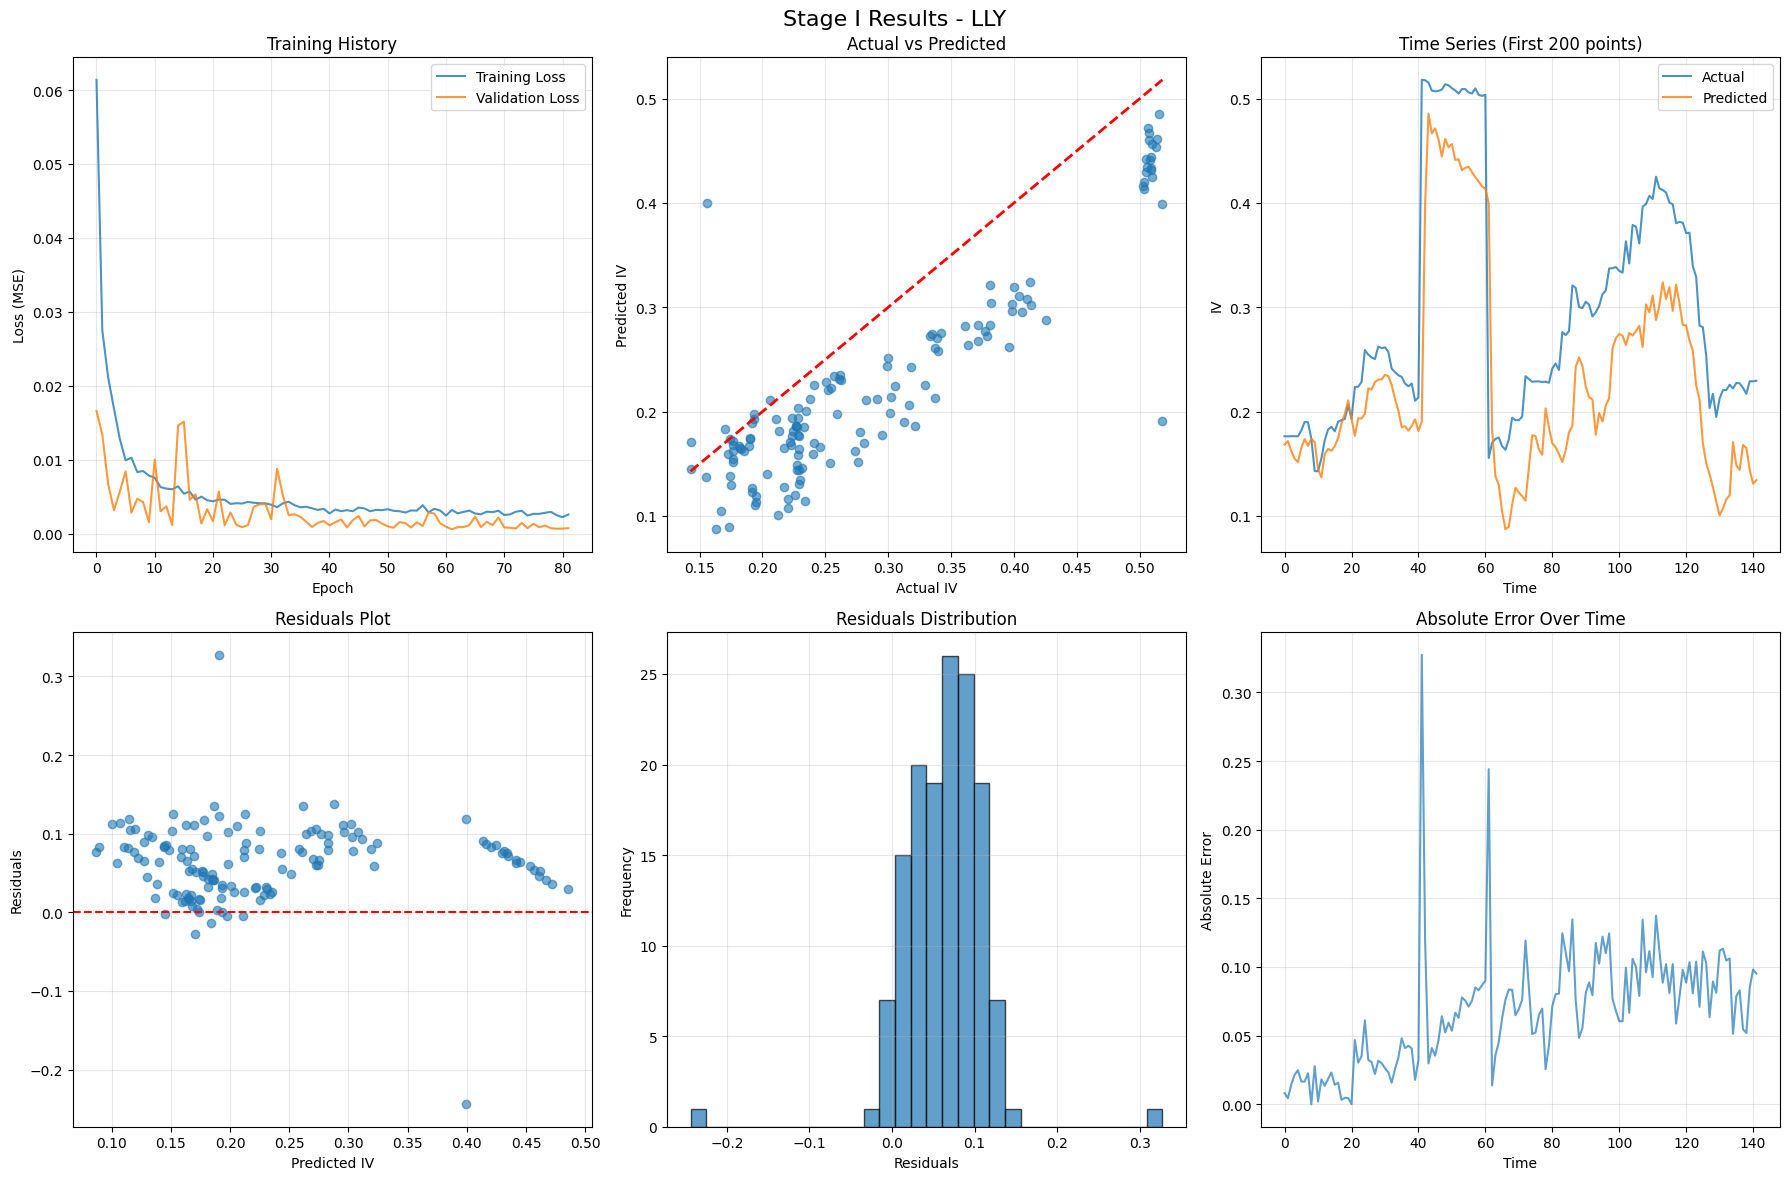

[*********************100%***********************]  1 of 1 completed
[I 2025-07-03 14:03:39,111] A new study created in memory with name: no-name-fbc1ecdc-bdfe-4964-92ed-3c3ac00a035f



Processing V...
Optimizing hyperparameters for V...


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [20/50], Train Loss: 0.005085, Val Loss: 0.001759
Epoch [40/50], Train Loss: 0.002789, Val Loss: 0.000501
[I 2025-07-03 14:04:28,440] Trial 0 finished with value: 0.00044083344012809295 and parameters: {'hidden_size': 64, 'num_layers': 2, 'dropout_rate': 0.3175417090119346, 'learning_rate': 0.0020811726146149523, 'batch_size': 64}. Best is trial 0 with value: 0.00044083344012809295.
Epoch [20/50], Train Loss: 0.005649, Val Loss: 0.004176
[I 2025-07-03 14:05:54,821] Trial 1 finished with value: 0.0013923569407779724 and parameters: {'hidden_size': 128, 'num_layers': 2, 'dropout_rate': 0.2198546564512642, 'learning_rate': 0.00022751530389563592, 'batch_size': 32}. Best is trial 0 with value: 0.00044083344012809295.
Epoch [20/50], Train Loss: 0.005805, Val Loss: 0.001779
Epoch [40/50], Train Loss: 0.003574, Val Loss: 0.000609
[I 2025-07-03 14:06:16,767] Trial 2 finished with value: 0.0005219917608580241 and parameters: {'hidden_size': 64, 'num_layers': 1, 'dropout_rate': 0.465669944

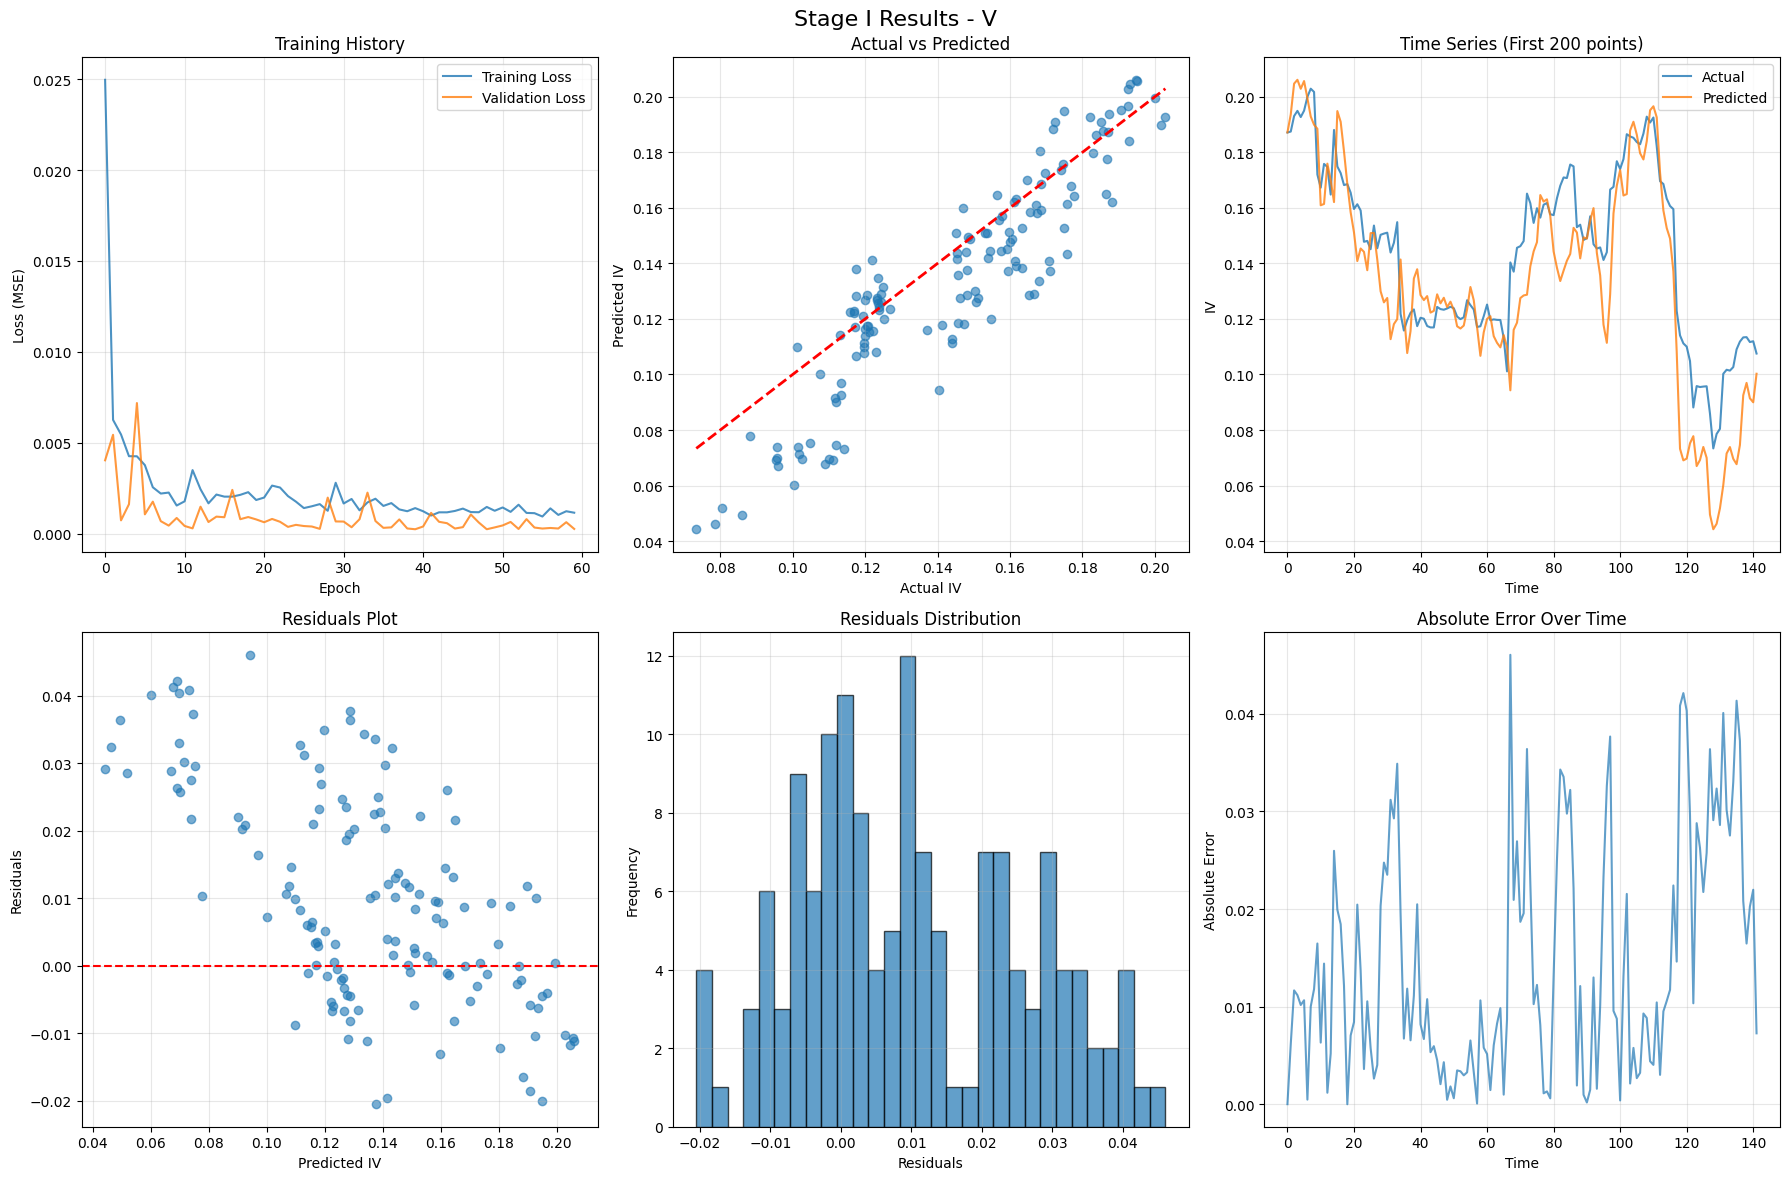

[*********************100%***********************]  1 of 1 completed
[I 2025-07-03 14:10:56,157] A new study created in memory with name: no-name-aaaa0a67-8ae1-480a-a989-46db70c5698b



Processing ORCL...
Optimizing hyperparameters for ORCL...


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [20/50], Train Loss: 0.002077, Val Loss: 0.008219
Epoch [40/50], Train Loss: 0.001968, Val Loss: 0.001522
[I 2025-07-03 14:11:48,287] Trial 0 finished with value: 0.00037735139485448597 and parameters: {'hidden_size': 128, 'num_layers': 1, 'dropout_rate': 0.4735809041807436, 'learning_rate': 0.006712832718821457, 'batch_size': 32}. Best is trial 0 with value: 0.00037735139485448597.
Epoch [20/50], Train Loss: 0.003599, Val Loss: 0.001470
Epoch [40/50], Train Loss: 0.003723, Val Loss: 0.001346
[I 2025-07-03 14:12:33,845] Trial 1 finished with value: 0.0004795857646968216 and parameters: {'hidden_size': 64, 'num_layers': 2, 'dropout_rate': 0.47944384501435144, 'learning_rate': 0.0030638814012810397, 'batch_size': 32}. Best is trial 0 with value: 0.00037735139485448597.
Epoch [20/50], Train Loss: 0.003516, Val Loss: 0.001800
Epoch [40/50], Train Loss: 0.002000, Val Loss: 0.000365
[I 2025-07-03 14:13:30,677] Trial 2 finished with value: 0.00030528583091735427 and parameters: {'hidden

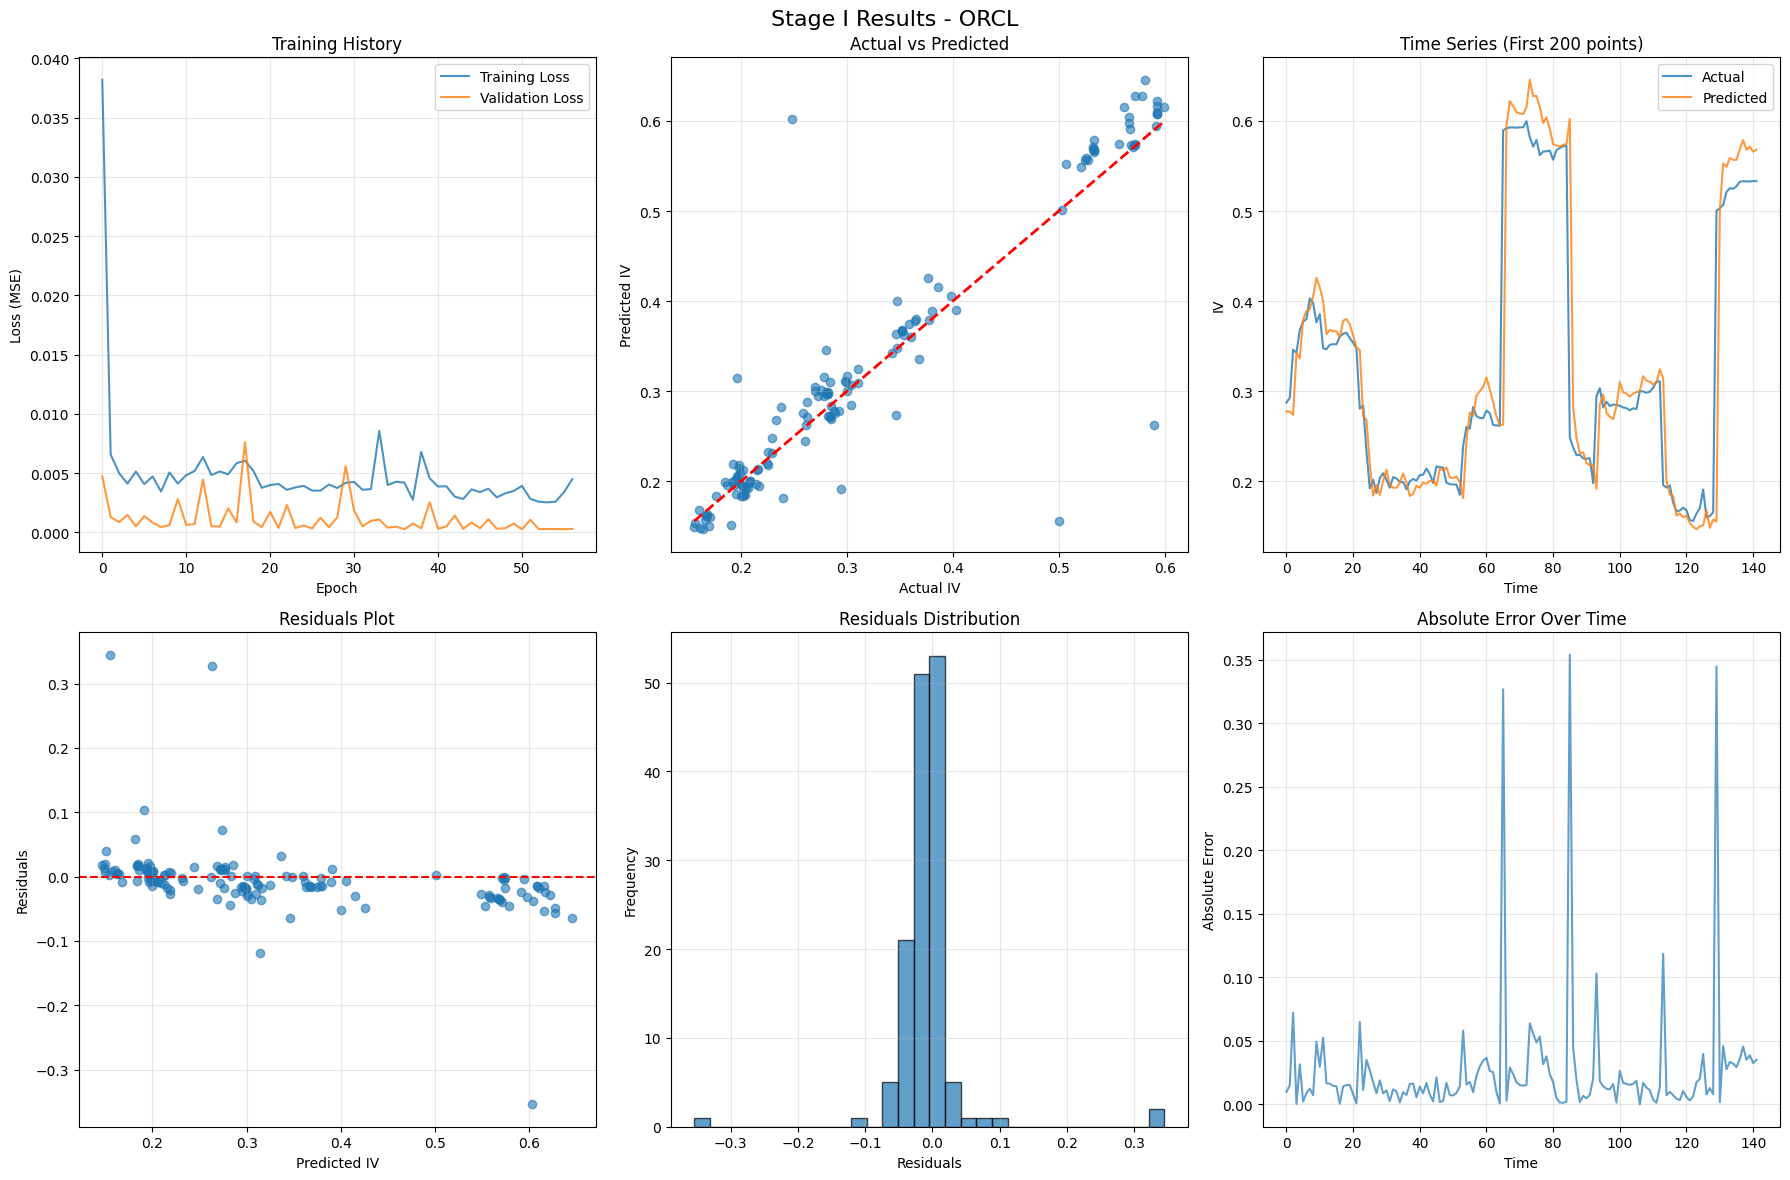

[*********************100%***********************]  1 of 1 completed
[I 2025-07-03 14:16:03,186] A new study created in memory with name: no-name-dc6fe4fa-1c9f-44da-9a9d-3db831a7a5c6



Processing NFLX...
Optimizing hyperparameters for NFLX...


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [20/50], Train Loss: 0.009152, Val Loss: 0.002507
Epoch [40/50], Train Loss: 0.006827, Val Loss: 0.002867
[I 2025-07-03 14:18:10,023] Trial 0 finished with value: 0.0007707394193857908 and parameters: {'hidden_size': 128, 'num_layers': 2, 'dropout_rate': 0.3417534923867842, 'learning_rate': 0.003837104624261389, 'batch_size': 32}. Best is trial 0 with value: 0.0007707394193857908.
Epoch [20/50], Train Loss: 0.006664, Val Loss: 0.001673
[I 2025-07-03 14:18:44,063] Trial 1 finished with value: 0.0010102871572598815 and parameters: {'hidden_size': 128, 'num_layers': 1, 'dropout_rate': 0.4646029469486278, 'learning_rate': 0.00028206821288322056, 'batch_size': 32}. Best is trial 0 with value: 0.0007707394193857908.
Epoch [20/50], Train Loss: 0.011254, Val Loss: 0.004112
Epoch [40/50], Train Loss: 0.008029, Val Loss: 0.002551
[I 2025-07-03 14:19:36,474] Trial 2 finished with value: 0.0018880412389989942 and parameters: {'hidden_size': 128, 'num_layers': 1, 'dropout_rate': 0.34629246523

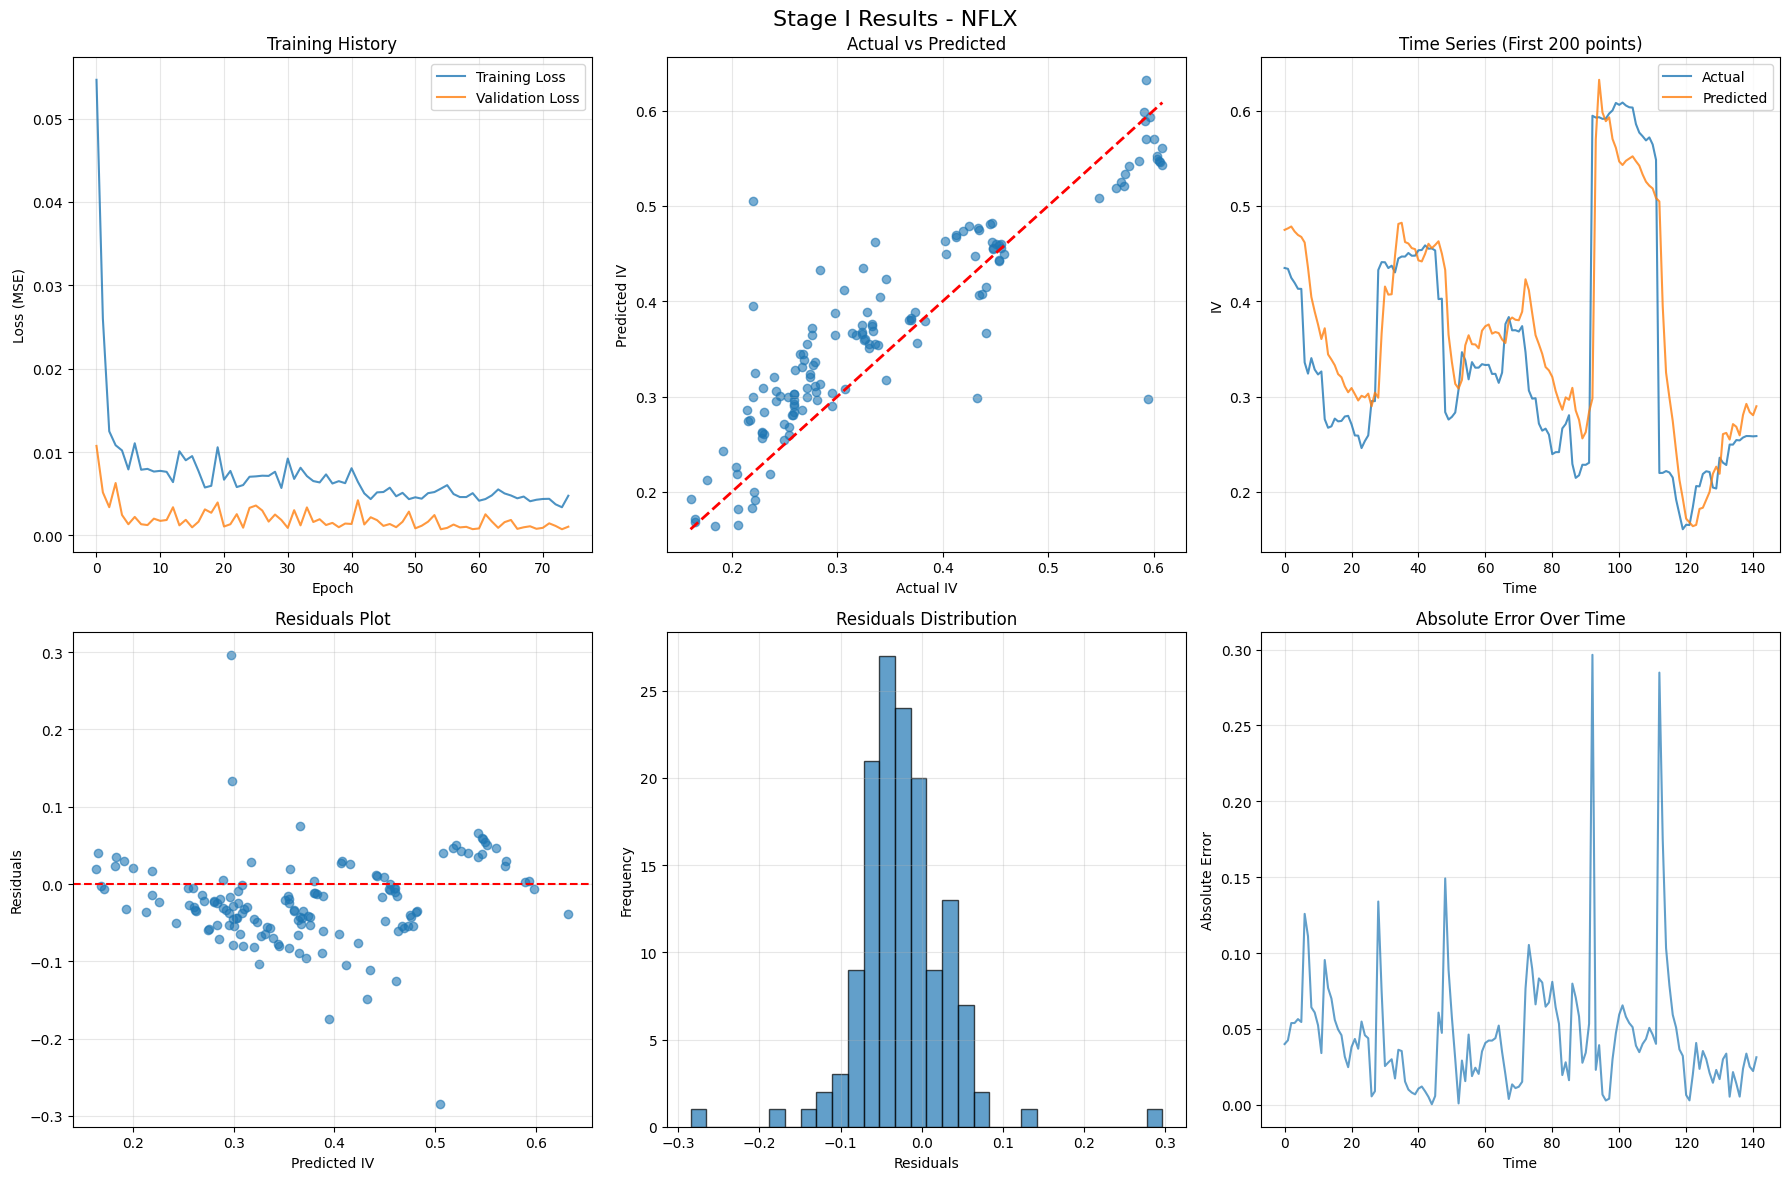


Processing XOM...


[*********************100%***********************]  1 of 1 completed
[I 2025-07-03 14:24:54,996] A new study created in memory with name: no-name-b5163af2-e633-4654-8563-8aec4a320577


Optimizing hyperparameters for XOM...


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [20/50], Train Loss: 0.012377, Val Loss: 0.022094
Epoch [40/50], Train Loss: 0.007412, Val Loss: 0.005335
[I 2025-07-03 14:25:48,496] Trial 0 finished with value: 0.0014486566958819619 and parameters: {'hidden_size': 64, 'num_layers': 2, 'dropout_rate': 0.29131224027789143, 'learning_rate': 0.00020209347330584713, 'batch_size': 16}. Best is trial 0 with value: 0.0014486566958819619.
Epoch [20/50], Train Loss: 0.009810, Val Loss: 0.043826
[I 2025-07-03 14:25:59,647] Trial 1 finished with value: 0.003374140321587523 and parameters: {'hidden_size': 64, 'num_layers': 1, 'dropout_rate': 0.11105186180546132, 'learning_rate': 0.00015200694467749985, 'batch_size': 64}. Best is trial 0 with value: 0.0014486566958819619.
Epoch [20/50], Train Loss: 0.014465, Val Loss: 0.004724
Epoch [40/50], Train Loss: 0.008371, Val Loss: 0.002403
[I 2025-07-03 14:26:22,378] Trial 2 finished with value: 0.00091219109405453 and parameters: {'hidden_size': 64, 'num_layers': 1, 'dropout_rate': 0.4931289876318

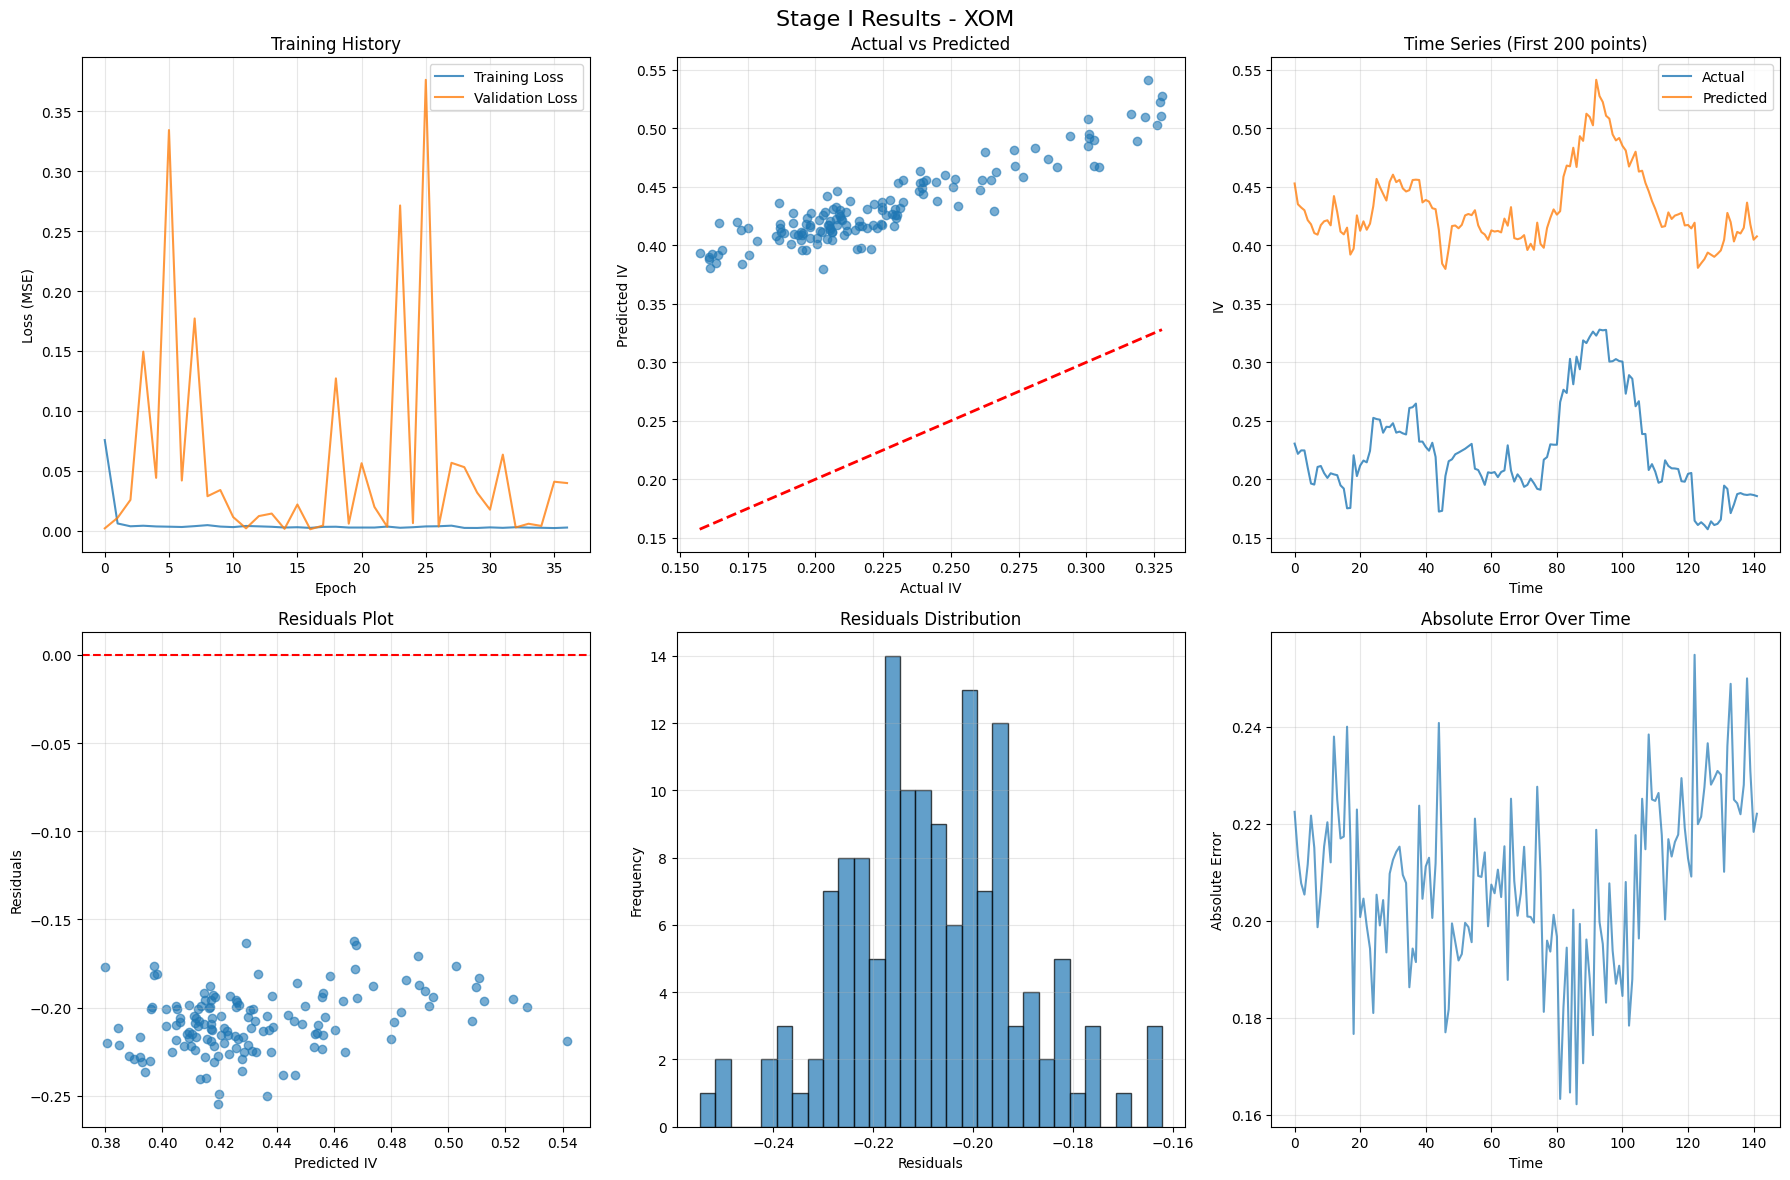


Processing MA...


[*********************100%***********************]  1 of 1 completed
[I 2025-07-03 14:29:09,092] A new study created in memory with name: no-name-ca15371d-5ba1-4383-929a-ce59394ec8f5


Optimizing hyperparameters for MA...


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [20/50], Train Loss: 0.003711, Val Loss: 0.001666
Epoch [40/50], Train Loss: 0.003148, Val Loss: 0.000926
[I 2025-07-03 14:31:16,387] Trial 0 finished with value: 0.0005516625911695883 and parameters: {'hidden_size': 128, 'num_layers': 2, 'dropout_rate': 0.4614212939036346, 'learning_rate': 0.001347949922928873, 'batch_size': 32}. Best is trial 0 with value: 0.0005516625911695883.
Epoch [20/50], Train Loss: 0.003489, Val Loss: 0.001540
Epoch [40/50], Train Loss: 0.002377, Val Loss: 0.000325
[I 2025-07-03 14:32:14,706] Trial 1 finished with value: 0.0002864446093250687 and parameters: {'hidden_size': 128, 'num_layers': 1, 'dropout_rate': 0.48169846818602413, 'learning_rate': 0.003435694742132043, 'batch_size': 16}. Best is trial 1 with value: 0.0002864446093250687.
Epoch [20/50], Train Loss: 0.005899, Val Loss: 0.045997
Epoch [40/50], Train Loss: 0.003327, Val Loss: 0.000849
[I 2025-07-03 14:34:20,391] Trial 2 finished with value: 0.0008491763190249912 and parameters: {'hidden_siz

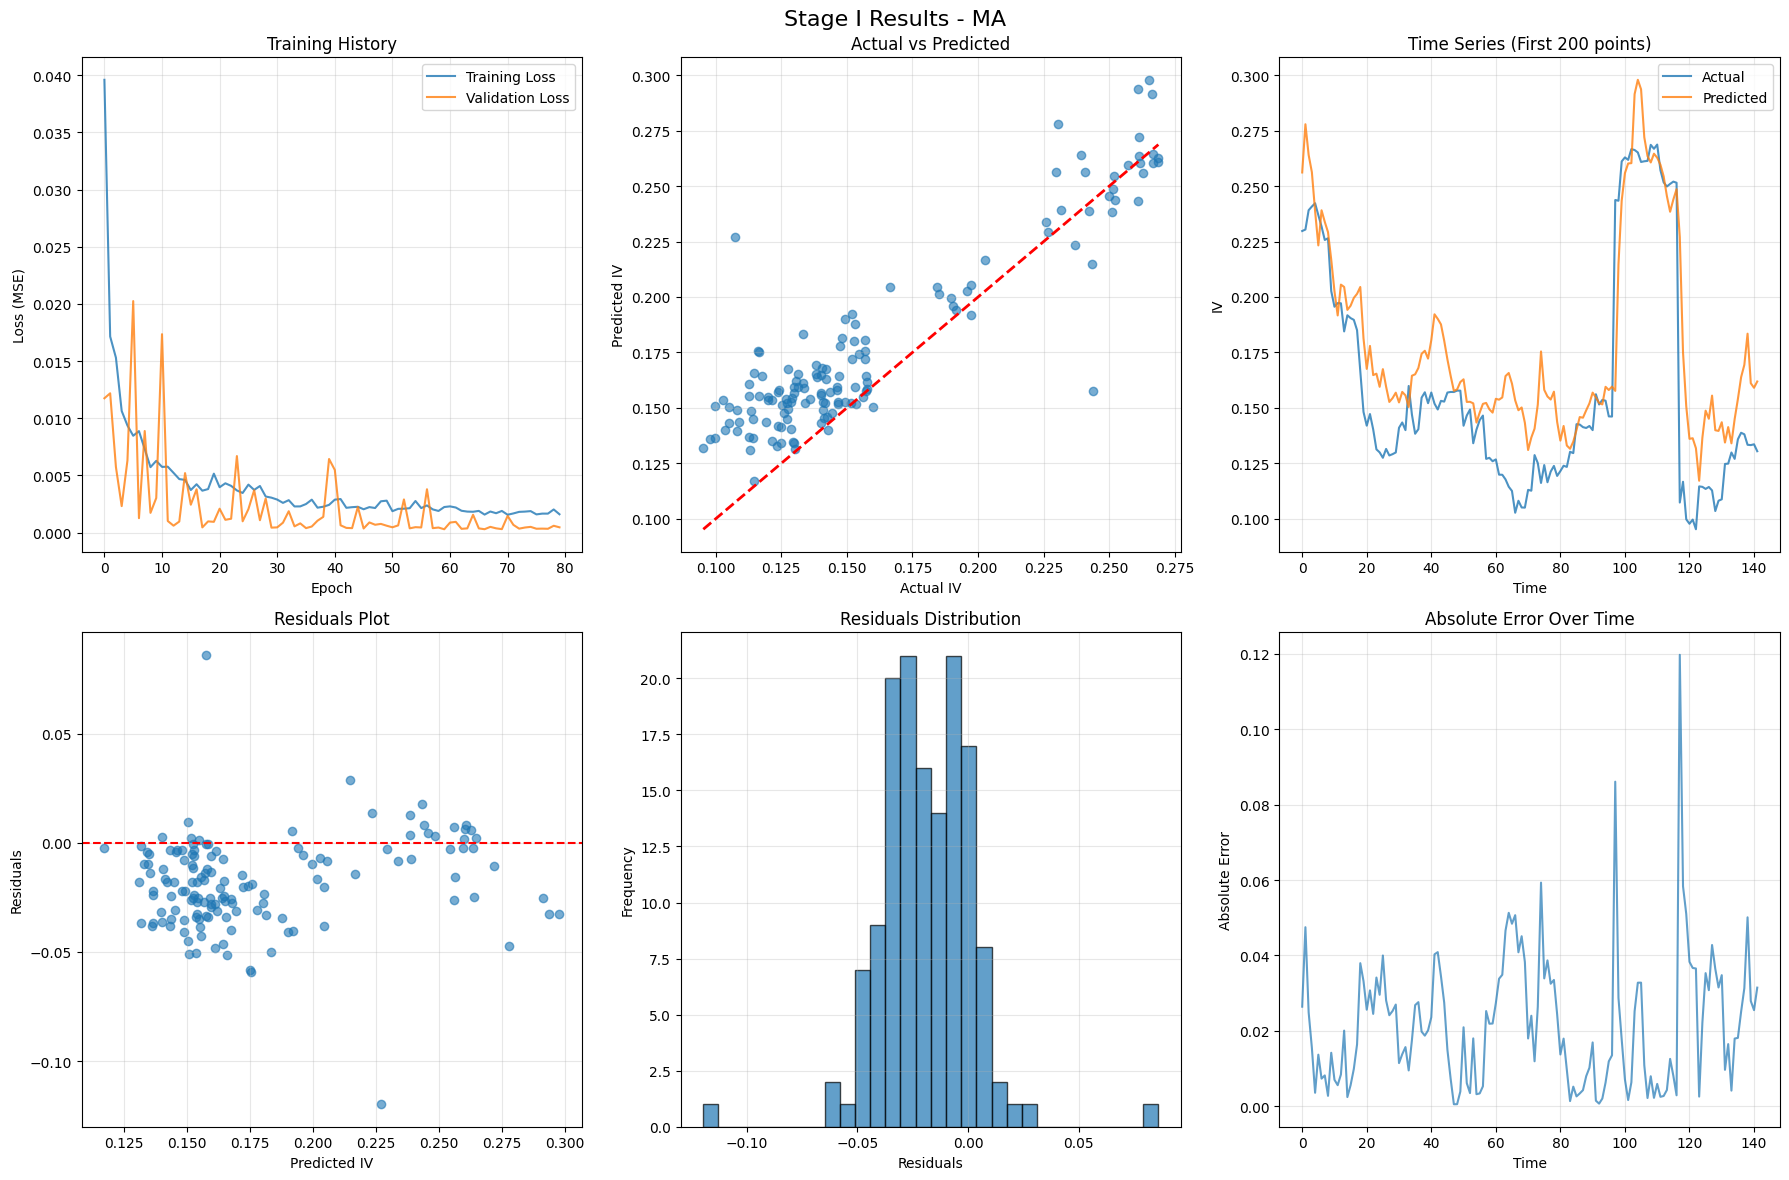


Processing COST...


[*********************100%***********************]  1 of 1 completed
[I 2025-07-03 14:37:49,665] A new study created in memory with name: no-name-cf6e5a8a-8a4e-4512-8f63-fc53981966f2


Optimizing hyperparameters for COST...


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [20/50], Train Loss: 0.005767, Val Loss: 0.004349
Epoch [40/50], Train Loss: 0.003723, Val Loss: 0.002851
[I 2025-07-03 14:38:11,994] Trial 0 finished with value: 0.0020822633911545077 and parameters: {'hidden_size': 64, 'num_layers': 1, 'dropout_rate': 0.1349716830481171, 'learning_rate': 0.0002103551459073389, 'batch_size': 64}. Best is trial 0 with value: 0.0020822633911545077.
Epoch [20/50], Train Loss: 0.004019, Val Loss: 0.002576
Epoch [40/50], Train Loss: 0.003622, Val Loss: 0.002184
[I 2025-07-03 14:40:18,907] Trial 1 finished with value: 0.0018716460559517144 and parameters: {'hidden_size': 128, 'num_layers': 2, 'dropout_rate': 0.39268065894606186, 'learning_rate': 0.0019643457678929785, 'batch_size': 32}. Best is trial 1 with value: 0.0018716460559517144.
Epoch [20/50], Train Loss: 0.003344, Val Loss: 0.002331
Epoch [40/50], Train Loss: 0.002442, Val Loss: 0.002015
[I 2025-07-03 14:40:43,452] Trial 2 finished with value: 0.0013730678125284611 and parameters: {'hidden_si

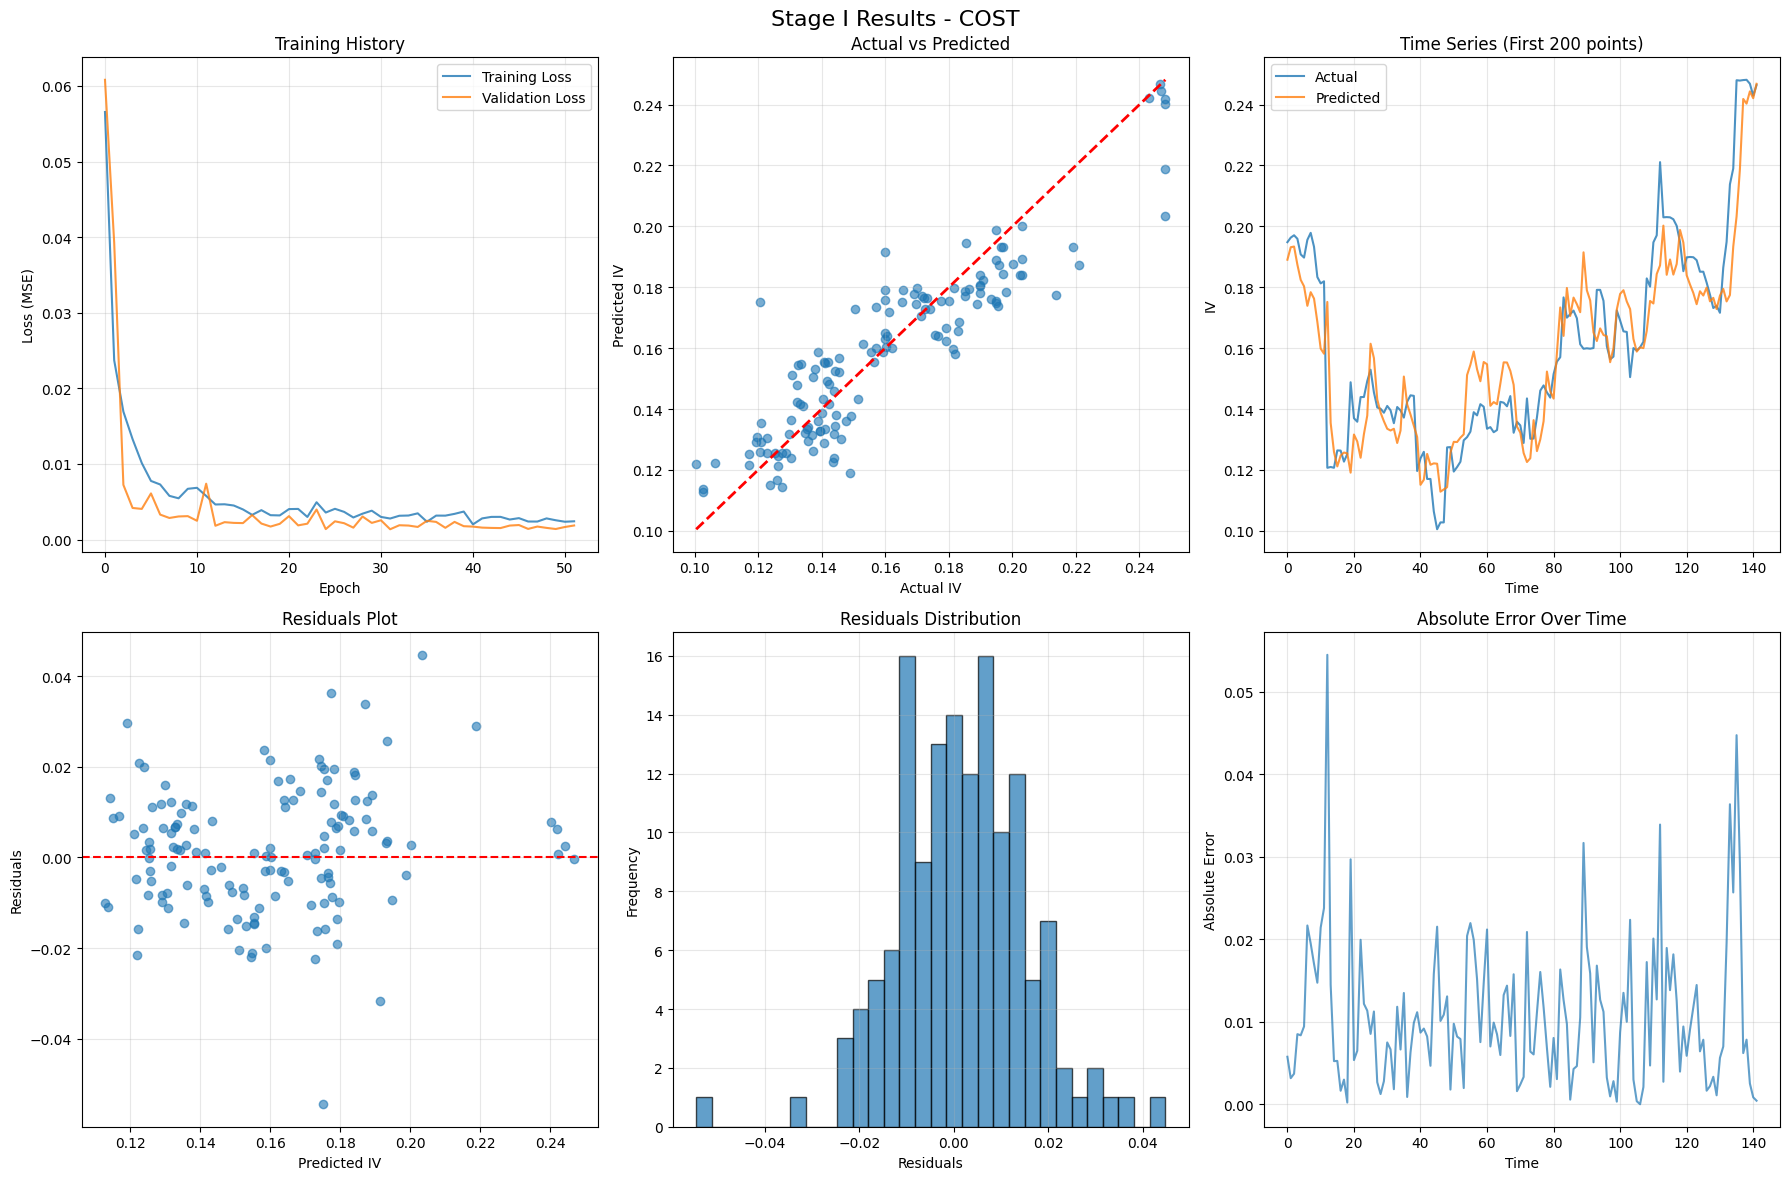


Processing PG...


[*********************100%***********************]  1 of 1 completed
[I 2025-07-03 14:44:35,302] A new study created in memory with name: no-name-d88b91ab-fbac-4203-8bf0-ba78a059b4f2


Optimizing hyperparameters for PG...


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [20/50], Train Loss: 0.001897, Val Loss: 0.000751
Epoch [40/50], Train Loss: 0.000867, Val Loss: 0.000426
[I 2025-07-03 14:45:03,533] Trial 0 finished with value: 0.0002747547457854833 and parameters: {'hidden_size': 64, 'num_layers': 1, 'dropout_rate': 0.1182996696799167, 'learning_rate': 0.0014758653026282617, 'batch_size': 16}. Best is trial 0 with value: 0.0002747547457854833.
Epoch [20/50], Train Loss: 0.003063, Val Loss: 0.000717
Epoch [40/50], Train Loss: 0.002706, Val Loss: 0.000622
[I 2025-07-03 14:47:05,547] Trial 1 finished with value: 0.00036466102917782136 and parameters: {'hidden_size': 128, 'num_layers': 2, 'dropout_rate': 0.4759724983534519, 'learning_rate': 0.0006256281463770207, 'batch_size': 16}. Best is trial 0 with value: 0.0002747547457854833.
Epoch [20/50], Train Loss: 0.001880, Val Loss: 0.005737
Epoch [40/50], Train Loss: 0.000946, Val Loss: 0.000597
[I 2025-07-03 14:48:03,849] Trial 2 finished with value: 0.00029601779533550143 and parameters: {'hidden_s

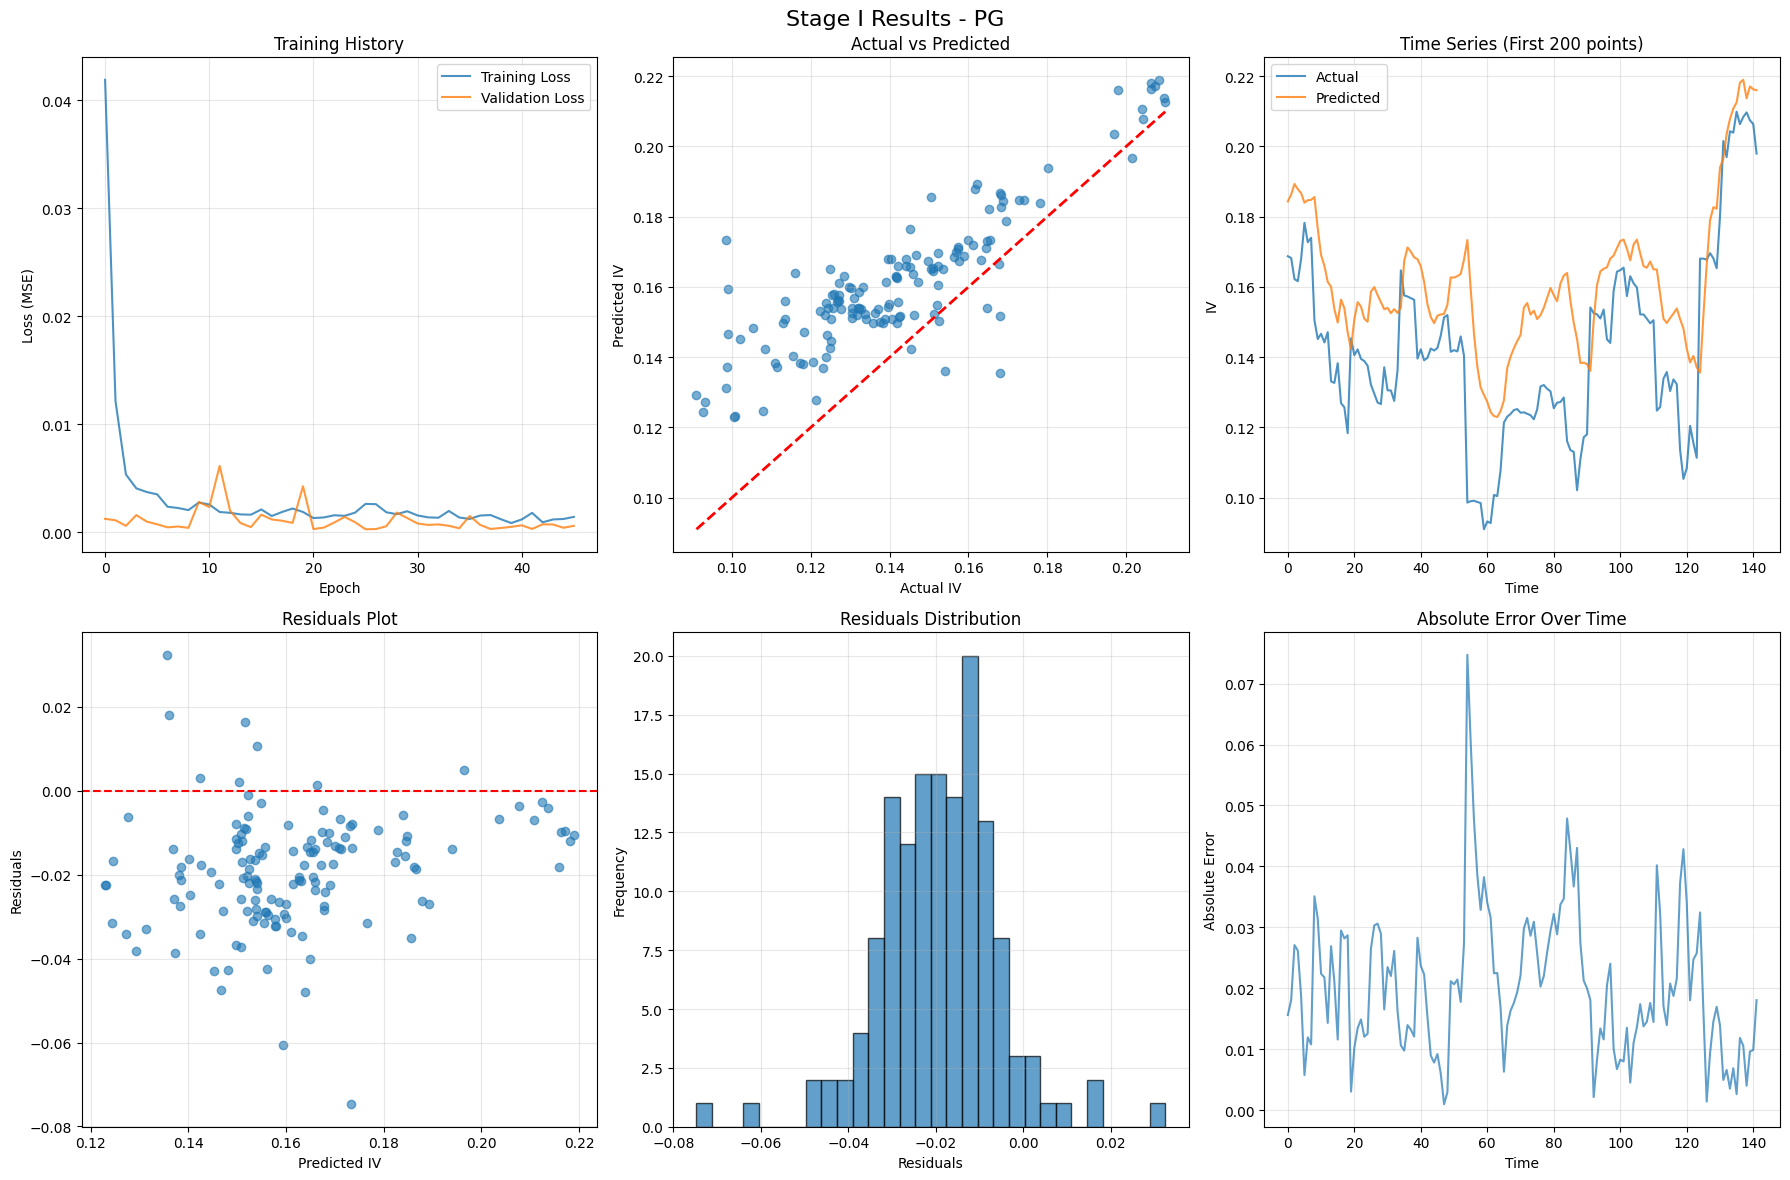


Stage I completed. Successfully processed 20 stocks.
Individual IV predictions available for: ['MSFT', 'NVDA', 'AAPL', 'AMZN', 'META', 'AVGO', 'TSLA', 'GOOGL', 'HD', 'GOOG', 'JPM', 'WMT', 'LLY', 'V', 'ORCL', 'NFLX', 'XOM', 'MA', 'COST', 'PG']
Stage I results saved to 'results/stage1_results.pkl'


In [12]:
# Stage 1: Individual Stock IV Prediction
import sys
import os

# Configuration
tickers = [
    "MSFT", "NVDA", "AAPL", "AMZN", "META", "AVGO", "TSLA", "GOOGL",
    "HD", "GOOG", "JPM", "WMT", "LLY", "V", "ORCL", "NFLX",
    "XOM", "MA", "COST", "PG"
]

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Create directories for saving models
os.makedirs('models/stage1', exist_ok=True)
os.makedirs('results', exist_ok=True)

print("="*80)
print("STAGE I: INDIVIDUAL STOCK IV PREDICTION")
print("="*80)

# Stage I Results Storage
stage1_results = {}
individual_iv_predictions = {}
stock_returns_data = {}

# Process each stock individually
for ticker in tickers:
    print(f"\nProcessing {ticker}...")

    try:
        # Download data
        stock_data = yf.download(ticker, start='2020-01-01', end='2024-01-01')

        if len(stock_data) < 200:
            print(f"Insufficient data for {ticker}")
            continue

        # Store returns for correlation calculation
        returns = np.log(stock_data['Close'] / stock_data['Close'].shift(1)).dropna()
        stock_returns_data[ticker] = returns

        # Create features
        processed_data = create_stock_features(stock_data)

        # Prepare sequences
        X, y, feature_scaler, target_scaler = prepare_stock_sequences(processed_data)

        # Train-validation-test split
        train_size = int(0.7 * len(X))
        val_size = int(0.15 * len(X))

        X_train, y_train = X[:train_size], y[:train_size]
        X_val, y_val = X[train_size:train_size+val_size], y[train_size:train_size+val_size]
        X_test, y_test = X[train_size+val_size:], y[train_size+val_size:]

        input_size = X.shape[2]

        # Hyperparameter optimization
        print(f"Optimizing hyperparameters for {ticker}...")
        best_params = optimize_lstm_hyperparameters(
            X_train, y_train, X_val, y_val, input_size, device, n_trials=6
        )

        # Create best model
        best_model = LSTMModel(
            input_size=input_size,
            hidden_size=best_params['hidden_size'],
            num_layers=best_params['num_layers'],
            dropout_rate=best_params['dropout_rate']
        ).to(device)

        # Create datasets with best batch size
        train_dataset = StockDataset(X_train, y_train)
        val_dataset = StockDataset(X_val, y_val)
        test_dataset = StockDataset(X_test, y_test)

        train_loader = DataLoader(train_dataset, batch_size=best_params['batch_size'], shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=best_params['batch_size'], shuffle=False)
        test_loader = DataLoader(test_dataset, batch_size=best_params['batch_size'], shuffle=False)

        # Train best model
        print(f"Training final model for {ticker}...")
        train_losses, val_losses, _ = train_lstm_model(
            best_model, train_loader, val_loader, 150, best_params['learning_rate'], device
        )

        # Save the best model
        model_path = f'models/stage1/{ticker}_best_model.pth'
        save_model(
            best_model,
            model_path,
            scalers=(feature_scaler, target_scaler),
            metadata={
                'ticker': ticker,
                'best_params': best_params,
                'input_size': input_size,
                'train_size': train_size,
                'val_size': val_size,
                'test_size': len(X_test)
            }
        )

        # Generate predictions for entire dataset
        best_model.eval()
        all_predictions = []

        all_dataset = StockDataset(X, y)
        all_loader = DataLoader(all_dataset, batch_size=best_params['batch_size'], shuffle=False)

        with torch.no_grad():
            for sequences, _ in all_loader:
                sequences = sequences.to(device)
                outputs = best_model(sequences)
                all_predictions.extend(outputs.cpu().numpy())

        # Convert back to original scale
        all_predictions = target_scaler.inverse_transform(np.array(all_predictions).reshape(-1, 1)).flatten()

        # Store predictions with proper index
        prediction_dates = processed_data.index[60:]  # Skip first 60 days used for sequences
        individual_iv_predictions[ticker] = pd.Series(all_predictions, index=prediction_dates[:len(all_predictions)])

        # Evaluate on test set
        test_predictions = []
        test_actuals = []

        with torch.no_grad():
            for sequences, targets in test_loader:
                sequences, targets = sequences.to(device), targets.to(device)
                outputs = best_model(sequences)
                test_predictions.extend(outputs.cpu().numpy())
                test_actuals.extend(targets.cpu().numpy())

        # Convert back to original scale
        test_predictions = target_scaler.inverse_transform(np.array(test_predictions).reshape(-1, 1)).flatten()
        test_actuals = target_scaler.inverse_transform(np.array(test_actuals).reshape(-1, 1)).flatten()

        # Calculate metrics
        mse = mean_squared_error(test_actuals, test_predictions)
        mae = mean_absolute_error(test_actuals, test_predictions)
        rmse = np.sqrt(mse)

        print(f"Stage I Results for {ticker}:")
        print(f"MSE: {mse:.6f}, MAE: {mae:.6f}, RMSE: {rmse:.6f}")

        # Plot results
        plot_stage1_results(train_losses, val_losses, test_actuals, test_predictions, ticker)

        # Store results
        stage1_results[ticker] = {
            'mse': mse, 'mae': mae, 'rmse': rmse,
            'model_path': model_path,
            'best_params': best_params,
            'scalers': (feature_scaler, target_scaler)
        }

    except Exception as e:
        print(f"Error processing {ticker}: {str(e)}")
        continue

print(f"\nStage I completed. Successfully processed {len(stage1_results)} stocks.")
print(f"Individual IV predictions available for: {list(individual_iv_predictions.keys())}")

# Save Stage I results
with open('results/stage1_results.pkl', 'wb') as f:
    pickle.dump({
        'stage1_results': stage1_results,
        'individual_predictions': individual_iv_predictions,
        'stock_returns_data': stock_returns_data
    }, f)

print("Stage I results saved to 'results/stage1_results.pkl'")


# **Stage 2 Execution**

In [ ]:
# Stage 2: Portfolio IV Prediction
import sys
import os

# Load Stage I results
print("Loading Stage I results...")
with open('results/stage1_results.pkl', 'rb') as f:
    stage1_data = pickle.load(f)

stage1_results = stage1_data['stage1_results']
individual_iv_predictions = stage1_data['individual_predictions']
stock_returns_data = stage1_data['stock_returns_data']

# Configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Create directories
os.makedirs('models/stage2', exist_ok=True)

# Portfolio weights (equal weight for simplicity)
portfolio_weights = [1.0/len(individual_iv_predictions)] * len(individual_iv_predictions)

print("\n" + "="*80)
print("STAGE II: PORTFOLIO IV PREDICTION")
print("="*80)

stage2_results = {}

# Continue to Stage II only if there are enough individual predictions
if len(individual_iv_predictions) >= 2:

    # Calculate correlation matrices
    if stock_returns_data:
        # Create returns DataFrame
        returns_df = pd.DataFrame(stock_returns_data)
        returns_df = returns_df.dropna()

        correlation_matrices, correlation_dates = calculate_correlation_matrix(returns_df, window=60)
        print(f"Calculated {len(correlation_matrices)} correlation matrices")

    else:
        print("No stock return data available for correlation calculation. Skipping Stage II.")
        sys.exit()

    # Create market data (simplified - using SPY as proxy)
    try:
        spy_data = yf.download('SPY', start='2020-01-01', end='2024-01-01')
        market_data = pd.DataFrame(index=spy_data.index)
        market_data['Market_Vol'] = calculate_realized_volatility(spy_data['Close'])

        # Try to get VIX data
        try:
            vix_data = yf.download('^VIX', start='2020-01-01', end='2024-01-01')
            market_data['VIX'] = vix_data['Close']
        except:
            print("VIX data not available, using market volatility only")

    except:
        market_data = None
        print("Market data not available")

    # Create portfolio features
    print("Creating portfolio features...")
    portfolio_features, common_dates = create_portfolio_features(
        individual_iv_predictions,
        portfolio_weights,
        correlation_matrices,
        correlation_dates,
        market_data
    )

    # Calculate portfolio IV targets
    print("Calculating portfolio IV targets...")
    portfolio_targets, target_dates = calculate_portfolio_iv_target(
        individual_iv_predictions,
        portfolio_weights,
        correlation_matrices,
        correlation_dates
    )

    # Align features and targets
    common_feature_target_dates = pd.Index(common_dates).intersection(target_dates)
    common_feature_target_dates = common_feature_target_dates.sort_values()

    aligned_portfolio_features = []
    aligned_portfolio_targets = []

    portfolio_features_df = pd.DataFrame(portfolio_features, index=common_dates)
    portfolio_targets_series = pd.Series(portfolio_targets, index=target_dates)

    for date in common_feature_target_dates:
        aligned_portfolio_features.append(portfolio_features_df.loc[date].values)
        aligned_portfolio_targets.append(portfolio_targets_series.loc[date])

    aligned_portfolio_features = np.array(aligned_portfolio_features)
    aligned_portfolio_targets = np.array(aligned_portfolio_targets)

    print(f"Portfolio dataset size: {len(aligned_portfolio_features)} samples")
    print(f"Feature dimension: {aligned_portfolio_features.shape[1]}")

    if len(aligned_portfolio_features) == 0:
        print("No aligned portfolio data available for Stage II. Exiting.")
        sys.exit()

    # Split data for Stage II
    train_size = int(0.7 * len(aligned_portfolio_features))
    val_size = int(0.15 * len(aligned_portfolio_features))

    X_train_p2 = aligned_portfolio_features[:train_size]
    y_train_p2 = aligned_portfolio_targets[:train_size]
    X_val_p2 = aligned_portfolio_features[train_size:train_size+val_size]
    y_val_p2 = aligned_portfolio_targets[train_size:train_size+val_size]
    X_test_p2 = aligned_portfolio_features[train_size+val_size:]
    y_test_p2 = aligned_portfolio_targets[train_size+val_size:]

    # Scale features for Stage II
    portfolio_scaler = StandardScaler()
    X_train_p2_scaled = portfolio_scaler.fit_transform(X_train_p2)
    X_val_p2_scaled = portfolio_scaler.transform(X_val_p2)
    X_test_p2_scaled = portfolio_scaler.transform(X_test_p2)

    # Model 1: MLP with hyperparameter optimization
    print("\nOptimizing MLP hyperparameters...")
    best_mlp_params = optimize_mlp_hyperparameters(
        X_train_p2_scaled, y_train_p2, X_val_p2_scaled, y_val_p2, device, n_trials=20
    )

    print("\nTraining optimized MLP Model...")

    # Create best MLP model
    hidden_sizes = []
    for i in range(best_mlp_params['n_layers']):
        hidden_sizes.append(best_mlp_params[f'hidden_size_{i}'])

    mlp_model = PortfolioMLPModel(
        input_size=X_train_p2_scaled.shape[1],
        hidden_sizes=hidden_sizes,
        dropout_rate=best_mlp_params['dropout_rate']
    ).to(device)

    # Create datasets
    train_dataset_p2 = PortfolioDataset(X_train_p2_scaled, y_train_p2)
    val_dataset_p2 = PortfolioDataset(X_val_p2_scaled, y_val_p2)
    test_dataset_p2 = PortfolioDataset(X_test_p2_scaled, y_test_p2)

    train_loader_p2 = DataLoader(train_dataset_p2, batch_size=best_mlp_params['batch_size'], shuffle=True)
    val_loader_p2 = DataLoader(val_dataset_p2, batch_size=best_mlp_params['batch_size'], shuffle=False)
    test_loader_p2 = DataLoader(test_dataset_p2, batch_size=best_mlp_params['batch_size'], shuffle=False)

    # Train MLP
    mlp_train_losses, mlp_val_losses, _ = train_portfolio_model(
        mlp_model, train_loader_p2, val_loader_p2, 200, best_mlp_params['learning_rate'], device
    )

    # Save MLP model
    mlp_model_path = 'models/stage2/mlp_best_model.pth'
    save_model(
        mlp_model,
        mlp_model_path,
        scalers=portfolio_scaler,
        metadata={
            'model_type': 'MLP',
            'best_params': best_mlp_params,
            'input_size': X_train_p2_scaled.shape[1],
            'hidden_sizes': hidden_sizes,
            'train_size': train_size,
            'val_size': val_size,
            'test_size': len(X_test_p2)
        }
    )

    # Evaluate MLP
    mlp_model.eval()
    mlp_predictions = []
    mlp_actuals = []

    with torch.no_grad():
        for features, targets in test_loader_p2:
            features, targets = features.to(device), targets.to(device)
            outputs = mlp_model(features)
            mlp_predictions.extend(outputs.cpu().numpy())
            mlp_actuals.extend(targets.cpu().numpy())

    mlp_predictions = np.array(mlp_predictions).flatten()
    mlp_actuals = np.array(mlp_actuals).flatten()

    # Calculate metrics
    mlp_mse = mean_squared_error(mlp_actuals, mlp_predictions)
    mlp_mae = mean_absolute_error(mlp_actuals, mlp_predictions)
    mlp_rmse = np.sqrt(mlp_mse)
    mlp_corr, _ = pearsonr(mlp_actuals, mlp_predictions)

    stage2_results['MLP'] = {
        'mse': mlp_mse, 'mae': mlp_mae, 'rmse': mlp_rmse, 'correlation': mlp_corr,
        'model_path': mlp_model_path, 'best_params': best_mlp_params
    }

    print(f"MLP Results - RMSE: {mlp_rmse:.6f}, MAE: {mlp_mae:.6f}, Correlation: {mlp_corr:.4f}")

    # Plot MLP results
    plot_stage2_results(mlp_train_losses, mlp_val_losses, mlp_actuals, mlp_predictions, "Optimized MLP")

    # Print summary
    print("\nStage I (Individual Stock IV) Results:")
    stage1_df = pd.DataFrame({
        ticker: {
            'RMSE': stage1_results[ticker]['rmse'],
            'MAE': stage1_results[ticker]['mae']
        } for ticker in stage1_results.keys()
    }).T
    print(stage1_df)

    print("\nStage II (Portfolio IV) Results:")
    stage2_df = pd.DataFrame(stage2_results).T
    print(stage2_df)

    # Save complete results
    with open('results/complete_results.pkl', 'wb') as f:
        pickle.dump({
            'stage1_results': stage1_results,
            'stage2_results': stage2_results,
            'individual_predictions': individual_iv_predictions,
            'portfolio_features': aligned_portfolio_features,
            'portfolio_targets': aligned_portfolio_targets,
            'portfolio_scaler': portfolio_scaler
        }, f)

    print("\nComplete results saved to 'results/complete_results.pkl'")

else:
    print("Not enough individual predictions for Stage II")


In [13]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


After running the above cell and following the authorization steps, your Google Drive will be mounted at `/content/drive`. You can then save the results file to a specific folder in your Drive, for example:

In [14]:
import shutil

# Define the source and destination paths
source_path = 'results/stage1_results.pkl'
destination_path = '/content/drive/MyDrive/your_folder_name/stage1_results.pkl' # Replace 'your_folder_name' with your desired folder

# Create the destination folder if it doesn't exist
import os
os.makedirs(os.path.dirname(destination_path), exist_ok=True)

# Copy the file
shutil.copy(source_path, destination_path)

print(f"Results saved to {destination_path}")

Results saved to /content/drive/MyDrive/your_folder_name/stage1_results.pkl


In [ ]:
import pickle
from google.colab import drive
import os

# Mount Google Drive (if not already mounted)
if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')
else:
    print("Google Drive already mounted.")

# Define the path to the saved file in your Drive
# Replace 'your_folder_name' with the actual folder name you used
saved_file_path = '/content/drive/MyDrive/your_folder_name/stage1_results.pkl'

# Load the data from the pickle file
try:
    with open(saved_file_path, 'rb') as f:
        loaded_stage1_data = pickle.load(f)

    # You can now access the loaded data
    loaded_stage1_results = loaded_stage1_data['stage1_results']
    loaded_individual_predictions = loaded_stage1_data['individual_predictions']
    # Access other keys as needed

    print(f"Successfully loaded data from {saved_file_path}")
    print(f"Number of stocks in loaded results: {len(loaded_stage1_results)}")

except FileNotFoundError:
    print(f"Error: File not found at {saved_file_path}. Please check the folder name and file path.")
except Exception as e:
    print(f"An error occurred while loading the file: {e}")